# Predict TripAdvisor Rating

In this competition we're provided with:
- train and test datasets of 40,000 and 10,000 samples respectivly and 9 features except target feature;
- target feature is **Rating** - discrete number.
- model with hyperparameters that we're **not allowed** to change;
- baseline that gives **MAE** = 0.212

Our model is **RandomForestRegressor**.

**The regression task** is to find dependencies between the defining variables and the variable being defined, if it is a **continuous number** (while we have **discrete number**).

As a **tree-based algorithm**:
- it does not require data normalization/scaling
- the presence of omissions does not significantly affect the construction of the tree
- a small change in the data can significantly affect the structure of the tree
- when working with continuous numeric features, the tree divides them into categories, and loses information
- the algorithm gives poor results if the tree is used to solve the classification problem with unbalanced classes (fortunatelly, we have totally balanced sampling)
- it is not recommended to use one-hot encoding with tree algorithms

Our model has following important **hyperparameters**:
- 'bootstrap': **True**
- 'criterion': '**mse**'
    - The function to measure the **quality of a split**.
    - **mse** for the **mean squared error**, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node
- 'max_depth': None
    - If None, then nodes are expanded until all leaves are pure or until all leaves contain less than **min_samples_split samples**.
- 'max_features': '**auto**'
    - The number of features to consider when looking for the best split
    - If “auto”, then **max_features = n_features**
- 'n_estimators': 100
- 'oob_score': False
    - Whether to use out-of-bag samples to estimate the generalization score.
- 'random_state': 42
    - Controls both:
        - the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) 
        - the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
- 'warm_start': False

*When using RandomForestRegressor with max_features = n_features it is generally recommended to normalize the features before fitting to prevent features with larger scales from dominating the splitting decisions solely based on their magnitude.*

**What has been done**:
1. New features:
    - restaurant type, area food, country food, spcialities were get from cuisine style feature
    - name of restaurant and its region were get from url
    - chain and chain_scale were get by grouping restaurants' names
    - lasts 2 reviews date delta and last review date delta with max date of review as well as positive and negative words scores were get from reviews feature
    - some normalized and scaled be city numerical features
    - some means and medians
    - polinomial features
    - dummy features
2. 27 tests of model with different features conbinations

**What has been achieved**:
1. Taking the initially provided data without filling up the gaps and adding to them the number of restaurants in the city and the number of kitchens in the restaurant gave the same result as baseline (even slightly better: 0.2124 vs 0.2118 MAE).
2. The 3 most important features stood out: **ranking, city_count, number_of_reviews_old**, and **ranking** takes about 50%.
3. Despite the fact that **city_count** is strongly correlated with **ranking**, this feature greatly improves the accuracy of training (0.212 vs 0.405 MAE). Together, these two parameters work better than when scaling **ranking** by city (0.212 vs 0.227 MAE).
4. Filling up the gaps led to an increase in the error (0.212 vs 0.223 MAE). Most likely, because by the presence of omissions, the samples are also balanced and the better way of filling up hasn't been found.
5. There is uderfitting of the model, since on the cross validation graph the train and test scores lines run parallel to each other.
6. Adding new features reduces the error to 0.198, but does not correct the situation with the uderfitting, since there are no new significant features.
7. Rounding predict with pitch 0.5 to make continious number discrete turn MAE 0.198 into 0.168 (0.1726 on the submission)


More details on the features:
- Restaurant_id: Restaurant ID
- City: City of the restaurant
- Cuisine Style: Kitchen
- Ranking: The rank of the restaurant relative to other restaurants in this city
- Price Range: Restaurant prices in 3 categories
- Number of Reviews: Number of reviews
- Reviews: 2 recent reviews and the dates of these reviews
- URL_TA: restaurant page on 'www.tripadvisor.com '
- ID_TA: Restaurant ID in TripAdvisor
- Rating: Restaurant Rating

For data investigation results go to 'Bella K [SF TripAdvisor Rating] EDA+NaNs'

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
from matplotlib import rcParams
#%config InlineBackend.figure_format = 'svg' # graphs in svg look clearer
plt.style.use('ggplot')  # beautiful graphs
plt.rcParams['figure.figsize'] = (12, 4)  # figure size

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from datetime import date

In [3]:
# make our experiments reproducible
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime(date.today().strftime('%Y-%m-%d'))
CURRENT_DATE

Timestamp('2023-05-18 00:00:00')

In [4]:
# fix the version of the packages
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

print('Size of the train dataset:', df_train.shape)
print('Size of the test dataset:', df_test.shape)
print('Size of the submission dataset:', sample_submission.shape, end='\n\n')

Size of the train dataset: (40000, 10)
Size of the test dataset: (10000, 9)
Size of the submission dataset: (10000, 2)



So we have 20% of the data as test

In [6]:
df_train.head()

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   
3   3458.0     5.0         NaN                3.0   
4    621.0     4.0    $$ - $$$               84.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

In [7]:
df_test.head()

Restaurant_id        City  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       Cuisine Style  Ranking Price Range  \
0                                     ['Bar', 'Pub']  12963.0    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   Number of Reviews                                            Reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              URL_TA      ID_TA  
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918  
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944  
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638  
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417  
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354

In [8]:
sample_submission.head()

Restaurant_id  Rating
0          id_0     2.0
1          id_1     2.5
2          id_2     4.0
3          id_3     1.0
4          id_4     4.0

# Model

In [9]:
df_train.Rating.unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.model_selection import cross_validate
#from sklearn.model_selection import cross_val_score

In [11]:
def get_X_y(df):
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
    test_data = df.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.rating.values            # наш таргет
    X = train_data.drop(['rating'], axis=1)
    
    return X, y

    
    
def get_prediction(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred


    
def get_metrics(model, y_pred, X_train, y_train, X_test, y_test):
    
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    
    # the coefficient of determination of the prediction - r2_score
    print('Train r2_score:', model.score(X_train, y_train))
    print('Test r2_score:', model.score(X_test, y_test), end='\n\n')
    
    print('Model parametrs:\n', model.get_params())
    
    plt.rcParams['figure.figsize'] = (10, 8)
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh', title='Feature importances')
    plt.show()
    
    
    
def modelizer(df):
    X, y = get_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model, y_pred = get_prediction(X_train, X_test, y_train)

    get_metrics(model, y_pred, X_train, y_train, X_test, y_test)
    
    return model, X, y



def plot_cv_metrics(cv_metrics):
    avg_r2_train, std_r2_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_r2_valid, std_r2_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] r2_score = {:.2f} +/- {:.2f}'.format(avg_r2_train, std_r2_train))
    print('[valid] r2_score = {:.2f} +/- {:.2f}'.format(avg_r2_valid, std_r2_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('r2_score', fontsize=15)
    plt.legend(fontsize=15)


In [12]:
# FOR TESTS
def get_metrics_for_dict(model, y_pred, X_train, y_train, X_test, y_test):
    
    models_dict[model_name].update({'MAE': metrics.mean_absolute_error(y_test, y_pred),
                                    'Train_r2_score': model.score(X_train, y_train),
                                    'Test r2_score': model.score(X_test, y_test),
                                    'nlargest': pd.Series(model.feature_importances_, index=X_train.columns).nlargest(8)
                                   })
    

def modelizer_for_dict(df):
    X, y = get_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model, y_pred = get_prediction(X_train, X_test, y_train)

    get_metrics_for_dict(model, y_pred, X_train, y_train, X_test, y_test)
    
    return model, X, y



def model_tests(model_name):
    data_num = data[models_dict[model_name]['columns']].select_dtypes(include='number').copy()
    data_num = data_num.fillna(0)

    model, X, y = modelizer_for_dict(data_num)

In [13]:
def get_metrics_round(model, y_pred, X_train, y_train, X_test, y_test):
    
    # rounding predict with pitch 0.5
    y_pred_round = []
    for item in y_pred:
        y_pred_round.append(round(item/0.5)*0.5)
    y_pred_round_array = np.asarray(y_pred_round)
    
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round_array)) # !!!!!
    
    # the coefficient of determination of the prediction - r2_score
    print('Train r2_score:', model.score(X_train, y_train))
    print('Test r2_score:', model.score(X_test, y_test), end='\n\n')
    
    print('Model parametrs:\n', model.get_params())
    
    plt.rcParams['figure.figsize'] = (10, 8)
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh', title='Feature importances')
    plt.show()



def modelizer_round(df):
    X, y = get_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model, y_pred = get_prediction(X_train, X_test, y_train)

    get_metrics_round(model, y_pred, X_train, y_train, X_test, y_test)
    
    return model, X, y


In [14]:
def get_prediction_modified(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, max_features='sqrt', 
                                  verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred



def modelizer_modified(df):
    X, y = get_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model, y_pred = get_prediction_modified(X_train, X_test, y_train)

    get_metrics_round(model, y_pred, X_train, y_train, X_test, y_test)
    
    return model, X, y


# Preprocessing

In [15]:
# FUNCTIONS

import collections

# count the number of mentions of unique values and get those that come across more than 1 time
def collect_repeated_items(col):
    c = collections.Counter()
    for el in data[col].tolist():
        c[el]+=1
    print('Unique values:', len(c))
    
    new_c = {k: v for k, v in c.items() if v > 1}
    print('Values repeated more then one time:', len(new_c))
    
    c_list = list(new_c.keys())
    
    return c_list



import math

# divide all restaurants into conditional groups by frequency of occurrence
def get_param_scale(cell):
    for el in percentile_75_list:
        if cell < el+1:
            cell = el
            break
    
    return cell


# take the percentile as a criterion
def get_percentile(pc, df, col):
    percentile_list = []
    percentile = 0
    col_max = max(df[col])

    while math.ceil(col_max) > math.ceil(percentile):
        percentile = math.ceil(np.percentile(df.loc[(df[col]>percentile)][col], pc))
        percentile_list.append(percentile)
        
    return percentile_list



# make a dictionary of the Cuisine Style frequency taking into account a certain parameter
def cuisine_count_dict(cell):
    c = collections.Counter()
    for el in cell:
        if el is not np.nan:
            if type(el)==list:
                for x in el:
                    c[x]+=1
            else:
                c[el]+=1
    
    c = {k: v for k, v in sorted(c.items(), key=by_value, reverse=True)}
    return c


# sort the dictionary in descending order of quantity
def by_value(item):
    return item[1]



# count the number of positive and negative words in the reviews
import re
import nltk
from nltk.corpus import stopwords

def get_words_list(cell):
    cell_text = ' '.join(cell)
    cell_text_new = re.sub(r'[.,?!:;()=-_\'\"]', '', cell_text)
    cell_words_list = cell_text_new.split(' ')
    cell_words_list = [w.strip() for w in cell_words_list if len(w) > 1 ]
    cell_words_list = [w.strip() for w in cell_words_list if w not in stopwords.words('english')]
    
    return cell_words_list


def get_positive_score(cell):
    cell_score = sum([1 for w in cell if w in pos_list])
    
    return cell_score


def get_negative_score(cell):
    cell_score = sum([1 for w in cell if w in neg_list])
    
    return cell_score



# in the case of chain==1, rest_type, area_food, country_food, specialties will be filled with mods by city and name
def get_mode(col):

    city_name_dict_1 = {}
    for city in data.query('sample==1').city.unique():
        city_name_dict_1.update({city: {'name': data.loc[(data['sample']==1)&(data['city']==city)&(data['chain']==1)&(data['name'].isna()==False)].groupby('name')[col].apply(lambda x: x.mode()).reset_index().to_dict('index')}})

    city_name_dict_1 = {k: v['name'] for k, v in city_name_dict_1.items()}
    city_name_dict_1 = {key: {v['name']: v[col] for k, v in city_name_dict_1[key].items()} for key, value in city_name_dict_1.items()}


    city_name_dict_0 = {}
    for city in data.query('sample==0').city.unique():
        city_name_dict_0.update({city: {'name': data.loc[(data['sample']==0)&(data['city']==city)&(data['chain']==1)&(data['name'].isna()==False)].groupby('name')[col].apply(lambda x: x.mode()).reset_index().to_dict('index')}})

    city_name_dict_0 = {k: v['name'] for k, v in city_name_dict_0.items()}
    city_name_dict_0 = {key: {v['name']: v[col] for k, v in city_name_dict_0[key].items()} for key, value in city_name_dict_0.items()}

    return city_name_dict_1, city_name_dict_0
    # {'Paris': {'231_east_street': 'Fast Food', ...}}
    
    
# in case of chain==0 rest_type_count, area_food_court, country_food_count, specialities_count
# fill in median by city and price_range
def get_median(col):

    city_price_dict_1 = {}
    for city in data.query('sample==1').city.unique():
        city_price_dict_1.update({city: {'price_range': data.loc[(data['sample']==1)&(data['city']==city)&(data['chain']==0)&(data['name'].isna()==False)].groupby('price_range')[col].median().reset_index().to_dict('index')}})

    city_price_dict_1 = {k: v['price_range'] for k, v in city_price_dict_1.items()}
    city_price_dict_1 = {key: {v['price_range']: round(v[col], 0) for k, v in city_price_dict_1[key].items()} for key, value in city_price_dict_1.items()}


    city_price_dict_0 = {}
    for city in data.query('sample==0').city.unique():
        city_price_dict_0.update({city: {'price_range': data.loc[(data['sample']==0)&(data['city']==city)&(data['chain']==0)&(data['name'].isna()==False)].groupby('price_range')[col].median().reset_index().to_dict('index')}})

    city_price_dict_0 = {k: v['price_range'] for k, v in city_price_dict_0.items()}
    city_price_dict_0 = {key: {v['price_range']: round(v[col], 0) for k, v in city_price_dict_0[key].items()} for key, value in city_name_dict_0.items()}

    return city_price_dict_1, city_price_dict_0
    # 'Krakow': {1.0: 1.0, 2.5: 1.0, 4.0: 2.0}


In [16]:
# LISTS

rest_type_list = ['Bar', 'Pub', 'Cafe', 'Fast Food', 'Steakhouse', 'Street Food', 'Gastropub',
                  'Wine Bar', 'Barbecue', 'Seafood', 'Pizza', 'Soups', 'Sushi', 'Diner',
                  'Grill', 'Brew Pub', 'Contemporary', 'Fusion', 'Delicatessen'
                 ]

area_food_list = ['Mediterranean', 'European', 'Scandinavian', 'Eastern European', 
                  'Central European', 'African', 'Middle Eastern', 'International', 'Arabic', 
                  'Southwestern', 'Asian', 'Central American', 'South American', 'Persian', 
                  'Latin', 'Balti', 'Caribbean', 'Minority Chinese', 'Cajun & Creole', 
                  'Native American', 'Yunnan', 'Xinjiang', 'Central Asian', 'Caucasian'
                 ]

country_food_list = ['Italian', 'French', 'Portuguese', 'Greek', 'Czech', 'British', 'Spanish',
                     'Norwegian', 'Moroccan', 'Indian', 'Thai', 'Dutch', 'Welsh', 'American',
                     'Scottish', 'Hungarian', 'Peruvian', 'Irish', 'Polish', 'Vietnamese',
                     'Lebanese', 'Turkish', 'Japanese', 'Austrian', 'Chinese', 'Danish',
                     'Korean', 'German', 'Swiss', 'Swedish', 'Australian', 'Mexican', 'Belgian',
                     'Argentinean', 'Tunisian', 'Russian', 'Nepali', 'Bangladeshi', 'Colombian',
                     'Sri Lankan', 'Pakistani', 'Israeli', 'Brazilian', 'Ethiopian', 
                     'Taiwanese', 'Indonesian', 'Malaysian', 'Venezuelan', 'Armenian', 
                     'Slovenian', 'Jamaican', 'Ecuadorean', 'Chilean', 'Hawaiian', 'Croatian',
                     'Cambodian', 'Afghani', 'Tibetan', 'Romanian', 'Mongolian', 'Singaporean',
                     'Filipino', 'Cuban', 'Canadian', 'Egyptian', 'Azerbaijani', 'Georgian',
                     'New Zealand', 'Ukrainian', 'Albanian', 'Polynesian', 'Uzbek',
                     'Salvadoran', 'Burmese', 'Fujian', 'Latvian'
                    ]

spcialities_list = ['Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options', 'Halal',
                    'Healthy', 'Kosher']



pos_list = ['excellend', 'wonderland', 'profect', 'outstand', 'excellentservice', 'yummmmmmmmmmmmmmmmmmmmmmmmmmmmm', 'besttt', 
 'awseome', 'tastyyyyy', 'fastest', 'reccommend', 'recomend', 'wonderland', 'reccomend', 'excelente', 'tidy', 'awsome',
 'awesome', 'finest', 'greatest', 'friendliest', 'tastiest', 'cheapest', 'freshest', 'yummiest', 'coolest', 
 'loveliest', 'quickest', 'lovelyest', 'fondest', 'juciest', 'sweetest', 'amazing', 'charming', 'welcoming', 
 'relaxing', 'stunning', 'exciting', 'breathtaking', 'loving', 'enjoying', 'astonishing', 'amaizing', 'fascinating',
'greeting', 'enchanting', 'recommending', 'impressing', 'understanding', 'amzing', 'outsanding', 'blessing', 'amusing',
'serviceamazing', 'supporting', 'ahmazing', 'ourstanding', 'captivating', 'aaaaamazing', 'amamzing', 'amassamazing',
'outshining', 'scintillating', 'exhilarating', 'appetising', 'mazing', 'amazzzzzing', 'amaaaaaaazing', 'placeamazing',
'amaaazing', 'amanzing', 'fingerlicking', 'mindblowing', 'momazing', 'appetizing', 'outstanging', 'wordamazing', 
'amazingamazing', 'enjoyed', 'excellen', 'serviceminded', 'personified', 'yummy', 'good', 'great', 'nice', 'excellent',
'delicious', 'tasty', 'fantastic', 'perfect', 'cheap', 'ok', 'pleasant', 'super', 'cool', 'fabulous', 'healthy', 'fine',
'brilliant', 'outstanding', 'affordable' 'cute', 'enjoyable', 'wow', 'delightful', 'unique', 'incredible' 'comfortable',
'delight', 'inexpensive', 'romantic', 'cheerful', 'proper', 'stylish', 'helpful', 'gorgeous', 'generous', 'intimate',
'attentive', 'chill', 'elegant', 'gourmet', 'impressed', 'excelent', 'ideal', 'fancy', 'exquisite', 'memorable', 
 'spectacular', 'tasteful', 'terrific', 'peaceful', 'extraordinary', 'exellent', 'spacious', 'wonderfull', 'magical',
'worthy', 'adorable', 'upscale', 'flavorful', 'marvellous', 'delicous', 'unbeatable', 'recommendable', 'gastronomic',
'flavourful', 'magnificent', 'scrumptious', 'impeccable', 'friendl', 'deliciousness', 'marvelous', 'tremendous', 
 'entertaining', 'fantastico', 'lovey', 'faultless', 'freshness', 'excellant', 'yummi', 'worthwhile', 'delectable',
'fantasic', 'confortable', 'execellent', 'energetic', 'tastefull', 'unmissable', 'hospitable', '5-star', 'precious',
'gentle', 'wondeful', 'exelent', 'delcious', 'fantastique', 'delucious', 'exclusive', 'fanastic', 'faithful', 'gracious',
'accurate', 'luxurious', 'superior', 'phantastic', 'goody', 'a-mazing', 'majestic', 'recomendable', 'resonable',
'magnificant', 'magnifico', 'bellisimo', 'gourm', 'unexpensive', 'significant', 'must-go-to', 'exzellent', 'wooow',
'appetite', 'shambolic', 'delicatessan', 'good-value', 'roomy', 'healthful', 'unlimited', 'palatable', 'wowww', 
 'goooood', 'delicious', 'quickeasy', '***amazing***', 'rome-antic', 'fresh', 'fast', 'incredible/', 'especi', 'tastyy',
'place-to-be', 'fabulous', 'gastromique', 'lovely-', 'likeable', 'comprehensive', 'representable', 'exceptionnal',
'testy', 'harmonious', 'grateful', 'firey', 'yummmmm', 'under-appreciated', 'splendiferous', 'superrrrrrrr', 'enjoyabl',
'great', '-fantastic', 'wondersful', 'über-delicious', 'extroardinary', 'woooww', 'wonderdful', 'friendlygood', 'tasty',
'absolutelypositivethe', 'amazing-', 'gastrochic', 'woww', 'flavorfull', 'amazinggggg', 'delicuous', 'peacfull', 
 '-reasonable', 'to-die-for', 'awessome', 'fantastic', 'excelletn', 'tastyyy', 'wunderfull', 'irresistible', 'woooo',
'well-prepared', 'curryexcelent', 'tasty-', 'excellenct', 'ethic', 'unicorn', 'teasty', 'inspirational', 'wondrful',
'remarcable', 'heathy', 'good', 'unedible', 'nice', 'reasonnable', 'friendlyhelpful', 'marevllous', 'deeeelicious', 
'wonderwull', 'de-li-ci-ous', 'excellento', 'excellet', 'enjoyed-tasty', 'delicious', 'fantasctic', 'competen', 'goodb',
'okey', 'excellent', 'funtastic', 'gret', 'pleasurable', 'oksome', 'well-above-average', 'recommandable', 'ecxcellent',
'good-tasting', 'tasty', 'delighthful', 'responsible', 'soul-warming', 'hospitali', 'compliment', 'surpricegreat', 
 'orgasm', 'top5', 'deliciousmeql', 'fantastissimo', 'enjoyable-', 'tasteunforgettable', 'eccccccezionale', 'goodie',
'aweaome', 'fairtrade', 'gastronomical', 'foodstaff-wow', 'fanatastic', 'presentable', 'date-worthy', 'okish', 
 'a-m-a-z-i-n-g', 'fenomenal', 'delighful', '-healthy', 'good', 'dishi', 'delishious', 'deligious', 'mind-blowing',
'peeeeeerfect', 'excellent-ish', 'greatt', 'execerlent', 'good-priced', 'amazng', 'delicious', 'excellent', 'profesional',
'wobderful', 'enjoyablel', 'super-excellent', 'rasonable', 'price-attractive', 'comfortable/authentic', 'razonable',
'goode', 'buonísimo', 'staff-great', 'delecious', 'foodexcellent', 'delicious', 'good', 'foodwonderful', 'work-friendly',
'kid-friendly', 'fantasstic', 'agood', 'prfect', 'positiv', 'inexpenssive', 'personale', 'best', 'friendly', 'lovely',
'fun', 'yummy', 'reasonably', 'perfectly', 'pleasantly', 'amazingly', 'incredibly', 'nicest', 'quickly', 'deliciously',
'exceptionally', 'frendly', 'wonderfully', 'warmly', 'delightfully', 'fantastically', 'fabulously', 'brilliantly', 
 'yummmmmm', 'gastronomically', 'comfortably', 'spotlessly', 'elegantly', 'tastefully', 'neatly', 'gently', 'oke', 
 'stunningly', 'frindly', 'amazlingly', 'lovingly', 'nice', 'freiendly', 'helpfulfriendly', 'exquisitly', 'outstandingly',
'loverly', 'excitingly', 'cheerfully', 'merely', 'friendlly', 'dog-friendly', 'super-friendl', 'lovelly', 'imaginatively',
'pleasently', 'stupendously', 'oki', 'privately', 'superfriendly', 'pleasurably', 'ĺovely', 'finger-lickingly', 'friéndly',
'lovvely', 'wondefully', 'kindly', 'sophisticated', 'welcomed', 'personalized', 'excited', 'delighted', 'skilled', 
 'talented', 'openminded', 'goodfood', 'mesmerised', 'sofisticated', 'fingerlickin', 'lovelier']

neg_list = ['expencieve', 'rude', 'dissappointment', 'robbery', 'rudest', 'pain', 'grumpy', 'racist', 'worst', 'dishonest', 
 'slowest', 'poorest', 'weakest', 'woest', 'crappiest', 'worest', 'ugliest', 'wettest', 'waiting', 'disgusting',
'boring', 'lacking', 'watering', 'shocking', 'underwhelming', 'cracking', 'buzzing', 'bustling', 'disapointing',
'misleading', 'dissapointing', 'confusing', 'depressing', 'annoying', 'poisoning', 'unwelcoming', 'discusting',
'unsatisfying', 'embarrassing', 'unprepossessing', 'wasting', 'uncaring', 'melting', 'suckling', 'obliging', 
'frustrating', 'uninteresting', 'freaking', 'smelling', 'overcharging', 'revolting', 'unconvincing', 'disapponiting',
'desappointing', 'dissappinting', 'overdoing', 'diasppointing', 'disppointing', 'disapoointing', 'missleading',
'appauling', 'disappearing', 'madding', 'unexciting', 'promissing', 'hustling', 'thumping', 'buzzling', 'mourning',
'raving', 'conflicting', 'lingering', 'poisening', 'infuriating', 'pining', 'overpricing', 'deteriorating', 'tiring',
'disconcerting', 'thrilling', 'disappoing', 'crackling', 'terrifying', 'sprawling', 'pretending', 'wasdisappointing',
'rushing', 'sneaking', 'isappointing', 'charging', 'milking', 'disturbing', 'overpriced', 'disapointed', 'microwaved',
'overprized', 'disinterested', 'stolen', 'ignored', 'destroyed', 'bullied', 'worn', 'enforced', 'buggered', 
 'otheroverrated', 'interrupted', 'oiled', 'deceived', 'killed', 'naught', 'bad', 'expensive', 'poor', 'terrible',
'avoid', 'awful', 'horrible', 'disappointed', 'trap', 'wrong', 'tasteless', 'loud', 'dreadful', 'odd', 'arrogant',
'unpleasant', 'rubbish', 'appalling', 'unprofessional', 'sick', 'horrendous', 'miserable', 'nasty', 'aggressive',
'expensiv', 'dangerous', 'over-priced', 'hectic', 'questionable', 'impolite', 'garlic', 'uncomfortable', 'disappoint',
'messy', 'unacceptable', 'disorganized', 'expensi', 'uninspiring', 'negative', 'rough', 'pathetic', 'fake', 'unhelpful',
'indifferent', 'difficult', 'disgraceful', 'aweful', 'costly', 'inadequate', 'filthy', 'undercooked', 'ridiculous',
'disrespectful', 'underwhelmed', 'horrid', 'desperate', 'fatty', 'unhappy', 'soulless', 'outrageous', 'disapointment',
'unimpressive', 'rouge', 'unremarkable', 'avoidable', 'stupid', 'shameful', 'unwelcome', 'expencive', 'deceptive',
'impersonal', 'unimaginative', 'unreliable', 'unsatisfactory', 'hideous', 'unfrie', 'over-cooked', 'inattentive',
'incomplete', 'rubish', 'upset', 'no-go', 'moldy', 'tragic', 'food/poor', 'funprofessional', 'looooong', 'foodweird',
'disastrous', 'unhealthy', 'unprofessi', 'buzzed', 'steamy', 'oversold', 'sleepy', 'poorish', 'disasterous', 
 'not-deserted', 'no-personality', 'conflictual', 'incoherent', 'unnecessary', 'tricky', 'incomprehensible', 
 'over-rated', 'unappealing', 'over-ambitious', 'dismissive', 'impresionante', 'обман/cheat', 'unattractive', 
 'non-sense', 'unacceptabl', 'apathetic', 'questionnable', 'untasty', 'fraudulent', 'useless', 'saltyyyyyyyy', 
 'disappointingterrible', 'fraude', 'unimpressible', 'place-nothing', 'insignificant', 'all-microwaved', 'aggresive',
'obligatory', 'terriblenomuch', 'disrespect', 'worn-out', 'foodquestionable', 'uunisaari', 'unhygenic', 'understaffe',
'uninspired', 'trashy', 'misogynistic', 'tertible', 'doubtful', 'indefinite', 'howful', 'unspectacular', 'sloooow', 
 'untasetiness', 'anti-customer', 'superficial', 'assertive', 'froid', 'misguide', 'not-great', 'ugliestoldest', 
 'ambiguous', 'unpleasent', 'frugal', 'uninportant', 'taseteless', 'awful-', 'unprofessionnal', 'unpolite', 'unreasonable',
'lamentable', 'slowl', 'staffexpensive', 'unaccomodating', 'orderavoidavoidavoid', 'stereotype', 'hit-and-miss', 
 'foxy', 'naughty', 'inconvenient', 'disappointing-', 'snobb', 'must-avoid', 'slurpilicious', 'ridicolous', 'dismal',
'undeserved', 'unintereste', 'underperforming', 'clumsy', 'reservationbut', 'unsatisfied', 'catastrophic', 'deplorable',
'pitiful', 'unsophisticated', 'thrash', 'scam', 'fails', 'mistake', 'ignorant', 'never', 'unfriendly', 'noisy', 'sadly',
'unfortunately', 'poorly', 'terribly', 'shockingly', 'badly', 'ridiculously' 'utterly', 'awfull', 'hardly', 'ugly', 
 'barely', 'madness', 'microscopic', 'horribly', 'unacceptably', 'silly', 'effortless', 'awfully', 'tremendously', 
 'absurdly', 'nosily', 'loudly', 'unfortunetly', 'nightmarishly', 'chaotically','devastatingly', 'unreasonably', 'purely',
'ludicrously', 'dangerously', 'unintentionally', 'insufficiently', 'unfirendly', 'inexplicably', 'painfully', 
 'disgustingly', 'smelly', 'desperately', 'ridicolously', 'apology', 'frustratingly', 'rudely', 'inordinately', 'pitty',
'disappointingly', 'diningunfortunately', 'annoyingly', 'horrifically', 'deviously', 'overrated', 'overcharged', 'ruined',
'overcooked', 'bored', 'wicked', 'disorganised', 'overcrowded', 'shocked', 'unorganized', 'cheated', 'insulted', 'spoiled',
 'disgusted', 'failed', 'robbed', 'scamed', 'humiliated', 'dismanered', 'yelled', 'annoyed', 'unimpressed', 'overestimated',
'dispointed', 'disapponted', 'spolied', 'underestimated', 'inexprienced', 'fooduncooked', 'poisoned', 'ashamed', 'worse']

In [17]:
# DATA

DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# important! for the correct processing of characteristics, we combine the train and the test into one dataset
df_train['sample'] = 1 # mark the train
df_test['sample'] = 0 # mark the test
df_test['Rating'] = 0 # in test we don't have column Rating, it's our target

data = df_test.append(df_train, sort=False).reset_index(drop=True) # combine
data.columns = [x.lower().replace(' ', '_') for x in data.columns]



# the structure of the list, but the data type is a string
# turn it into a list
data['cuisine_style'] = data['cuisine_style'].dropna().apply(lambda x: x[2:-2].split("', '"))
# count the number of kitchens
data['cuisine_style_count'] = data['cuisine_style'].dropna().apply(lambda x: len(x))

data['price_range'] = data['price_range'].dropna().apply(lambda x: 1.0 if x=='$' else (2.5 if x=='$$ - $$$' else(4.0 if x=='$$$$' else x)))


city_count_1 = data.query('sample==1')['city'].value_counts()
city_count_0 = data.query('sample==0')['city'].value_counts()
data['city_count'] = data['city'].dropna().apply(lambda x: city_count_1[x] if x in city_count_1.index else (city_count_0[x] if x in city_count_0.index else np.nan))


# get the data about the name of the restaurant (or chain?), the region and some other g-code from URL_TA
data['name'] = data['url_ta'].dropna().apply(lambda x: x.split('-')[4].replace('.html', ''))
data['region'] = data['url_ta'].dropna().apply(lambda x: x.split('-')[5].replace('.html', '') if len(x.split('-'))>5 else x.split('-')[4].replace('.html', ''))
data['g_code'] = data['url_ta'].dropna().apply(lambda x: x.split('-')[1])
# in some cases, there is no indication of the name, then the region is pulled up - let's fix it
data.iloc[data.loc[data['name'] == data['region']].index.tolist(), data.columns.tolist().index('name')] = np.nan
data['name'] = data['name'].dropna().apply(lambda x: x.lower())
data['region'] = data['region'].dropna().apply(lambda x: x.lower())


name_count_1 = data.loc[(data['sample']==1)&(data['name'].isna()==False)]['name'].value_counts()
name_count_0 = data.loc[(data['sample']==0)&(data['name'].isna()==False)]['name'].value_counts()
data['name_count'] = data['name'].apply(lambda x: name_count_1[x] if x in name_count_1.index else (name_count_0[x] if x in name_count_0.index else 1))

data['chain'] = data['name_count'].dropna().apply(lambda x: 0 if x==1 else 1)
# take 75 percentile as a criterion
percentile_75_list = get_percentile(75, data.query('sample==1'), 'name_count') # chain_scale
data['chain_scale'] = data['name_count'].dropna().apply(get_param_scale)


gcode_count_1 = data.query('sample==1')['g_code'].value_counts()
gcode_count_0 = data.query('sample==0')['g_code'].value_counts()
data['gcode_count'] = data['g_code'].dropna().apply(lambda x: gcode_count_1[x] if x in gcode_count_1.index else (gcode_count_0[x] if x in gcode_count_0.index else np.nan))


# the structure of the lists in the list (review and dates), but the data type is a string
# turning empty lists into nan and strings into lists
data['reviews'] = data['reviews'].dropna().apply(lambda x: np.nan if x == '[[], []]' else x[2:-2].split("], ["))

# at the same time, we separate the review and turn the data into lists
data['reviews_text'] = data['reviews'].dropna().apply(lambda x: x[0][1:-1].split("', '"))

# separate the dates from the review and turn the data into lists
data['reviews_date'] = data['reviews'].dropna().apply(lambda x: x[1][1:-1].split("', '"))
# turning strings into dates
data['reviews_date'] = data['reviews_date'].dropna().apply(lambda x: [pd.to_datetime(i) for i in x])
data['reviews_date_last'] = data['reviews_date'].dropna().apply(lambda x: max(x))
reviews_date_max_1 = max(data.loc[data['sample']==1]['reviews_date_last'].dropna().tolist())
data['reviews_date_delta'] = data['reviews_date'].dropna().apply(lambda x: (max(x) - min(x)).days)
data['reviews_date_delta_max'] = data['reviews_date'].dropna().apply(lambda x: (reviews_date_max_1 - max(x)).days)



data['rest_type'] = data['cuisine_style'].dropna().apply(lambda x: [st for st in rest_type_list if st in x])
data['rest_type_count'] = data['rest_type'].dropna().apply(lambda x: len(x))
data['rest_type'] = data['rest_type'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

data['area_food'] = data['cuisine_style'].dropna().apply(lambda x: [st for st in area_food_list if st in x])
data['area_food_count'] = data['area_food'].dropna().apply(lambda x: len(x))
data['area_food'] = data['area_food'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

data['country_food'] = data['cuisine_style'].dropna().apply(lambda x: [st for st in country_food_list if st in x])
data['country_food_count'] = data['country_food'].dropna().apply(lambda x: len(x))
data['country_food'] = data['country_food'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

data['spcialities'] = data['cuisine_style'].dropna().apply(lambda x: [st for st in spcialities_list if st in x])
data['spcialities_count'] = data['spcialities'].dropna().apply(lambda x: len(x))
data['spcialities'] = data['spcialities'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

In [18]:
# NaNs

# price_range

def round_to_closest(number, lst=[1.0, 2.5, 4.0]):
    return min(lst, key=lambda x: abs(x - number))

price_range_dict = {}
for city in data.query('sample==1').city.unique():
    price_range_dict.update({city: {'chain_scale': data.loc[(data['sample']==1)&(data['city']==city)].groupby('chain_scale')['price_range'].mean().reset_index().to_dict('index')}})
        
price_range_dict = {k: v['chain_scale'] for k, v in price_range_dict.items()}
price_range_dict = {key: {v['chain_scale']: round_to_closest(v['price_range']) if math.isnan(v['price_range'])==False else np.nan for k, v in price_range_dict[key].items()} for key, value in price_range_dict.items()}

data['price_range_old'] = data['price_range']
data['price_range'] = data.apply(lambda x: price_range_dict[x['city']][x['chain_scale']] if math.isnan(x['price_range_old'])==True else x['price_range'], axis=1)
data['price_range'] = data['price_range'].fillna(2.5)


# number_of_reviews

num_rev_cuisine_dict = {}
for city in data.query('sample==1').city.unique():
    num_rev_cuisine_dict.update({city: {'cuisine_style_count': data.loc[(data['sample']==1)&(data['city']==city)&(data['cuisine_style_count'].isna()==False)].groupby('cuisine_style_count')['number_of_reviews'].median().reset_index().to_dict('index')}})
        
num_rev_cuisine_dict = {k: v['cuisine_style_count'] for k, v in num_rev_cuisine_dict.items()}
num_rev_cuisine_dict = {key: {v['cuisine_style_count']: v['number_of_reviews'] if math.isnan(v['number_of_reviews'])==False else np.nan for k, v in num_rev_cuisine_dict[key].items()} for key, value in num_rev_cuisine_dict.items()}


num_rev_price_dict = {}
for city in data.query('sample==1').city.unique():
    num_rev_price_dict.update({city: {'price_range': data.loc[(data['sample']==1)&(data['city']==city)].groupby('price_range')['number_of_reviews'].median().reset_index().to_dict('index')}})
        
num_rev_price_dict = {k: v['price_range'] for k, v in num_rev_price_dict.items()}
num_rev_price_dict = {key: {v['price_range']: v['number_of_reviews'] if math.isnan(v['number_of_reviews'])==False else np.nan for k, v in num_rev_price_dict[key].items()} for key, value in num_rev_price_dict.items()}


data['number_of_reviews_old'] = data['number_of_reviews']

data['number_of_reviews'] = data.apply(lambda x: num_rev_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['number_of_reviews_old'])==True and math.isnan(x['cuisine_style_count'])==False else x['number_of_reviews'], axis=1)
data['number_of_reviews'] = data.apply(lambda x: num_rev_price_dict[x['city']][x['price_range']] if math.isnan(x['number_of_reviews'])==True else x['number_of_reviews'], axis=1)



# cuisine_style

# instead of name_count, let's count name_city_count
city_name_dict_1 = {}
for city in data.query('sample==1').city.unique():
    city_name_dict_1.update({city: {'name': data.loc[(data['sample']==1)&(data['city']==city)&(data['name'].isna()==False)].groupby('name')['id_ta'].count().reset_index().to_dict('index')}})

city_name_dict_1 = {k: v['name'] for k, v in city_name_dict_1.items()}
city_name_dict_1 = {key: {v['name']: v['id_ta'] if math.isnan(v['id_ta'])==False else np.nan for k, v in city_name_dict_1[key].items()} for key, value in city_name_dict_1.items()}


city_name_dict_0 = {}
for city in data.query('sample==0').city.unique():
    city_name_dict_0.update({city: {'name': data.loc[(data['sample']==0)&(data['city']==city)&(data['name'].isna()==False)].groupby('name')['id_ta'].count().reset_index().to_dict('index')}})

city_name_dict_0 = {k: v['name'] for k, v in city_name_dict_0.items()}
city_name_dict_0 = {key: {v['name']: v['id_ta'] if math.isnan(v['id_ta'])==False else np.nan for k, v in city_name_dict_0[key].items()} for key, value in city_name_dict_0.items()}

# {'Paris': {015_gang_nam': 1}, ...}

data['name_city_count'] = data.apply(lambda x: city_name_dict_1[x['city']][x['name']] if x['name'] in list(city_name_dict_1[x['city']].keys()) else (city_name_dict_0[x['city']][x['name']] if x['name'] in list(city_name_dict_0[x['city']].keys()) else 1), axis=1)
data = data.drop('name_count', axis=1)


data['rest_type_old'] = data['rest_type']
data['area_food_old'] = data['area_food']
data['country_food_old'] = data['country_food']
data['spcialities_old'] = data['spcialities']

# in the case of chain==1 rest_type, area_food, country_food, specialties fill in with modes by city and name
city_name_dict_1, city_name_dict_0 = get_mode('rest_type')
data['rest_type'] = data.apply(lambda x: city_name_dict_1[x['city']][x['name']] if x['name'] in list(city_name_dict_1[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else (city_name_dict_0[x['city']][x['name']] if x['name'] in list(city_name_dict_0[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['rest_type']), axis=1)

city_name_dict_1, city_name_dict_0 = get_mode('area_food')
data['area_food'] = data.apply(lambda x: city_name_dict_1[x['city']][x['name']] if x['name'] in list(city_name_dict_1[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else (city_name_dict_0[x['city']][x['name']] if x['name'] in list(city_name_dict_0[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['area_food']), axis=1)

city_name_dict_1, city_name_dict_0 = get_mode('country_food')
data['country_food'] = data.apply(lambda x: city_name_dict_1[x['city']][x['name']] if x['name'] in list(city_name_dict_1[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else (city_name_dict_0[x['city']][x['name']] if x['name'] in list(city_name_dict_0[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['country_food']), axis=1)

city_name_dict_1, city_name_dict_0 = get_mode('spcialities')
data['spcialities'] = data.apply(lambda x: city_name_dict_1[x['city']][x['name']] if x['name'] in list(city_name_dict_1[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else (city_name_dict_0[x['city']][x['name']] if x['name'] in list(city_name_dict_0[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['spcialities']), axis=1)

# recalculate all ..._count
data['rest_type_count'] = data['rest_type'].dropna().apply(lambda x: len(x.split(', ')))
data['area_food_count'] = data['area_food'].dropna().apply(lambda x: len(x.split(', ')))
data['country_food_count'] = data['country_food'].dropna().apply(lambda x: len(x.split(', ')))
data['spcialities_count'] = data['spcialities'].dropna().apply(lambda x: len(x.split(', ')))

# in the case of chain==0 cuisine_style_count, rest_type_count, area_food_count, country_food_count, spcialities_count, 
# fill in with median by city and price_range
city_price_dict_1, city_price_dict_0 = get_median('rest_type_count')
data['rest_type_count'] = data.apply(lambda x: city_price_dict_1[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else (city_price_dict_0[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['rest_type_count']), axis=1)

city_price_dict_1, city_price_dict_0 = get_median('area_food_count')
data['area_food_count'] = data.apply(lambda x: city_price_dict_1[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else (city_price_dict_0[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['area_food_count']), axis=1)

city_price_dict_1, city_price_dict_0 = get_median('country_food_count')
data['country_food_count'] = data.apply(lambda x: city_price_dict_1[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else (city_price_dict_0[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['country_food_count']), axis=1)

city_price_dict_1, city_price_dict_0 = get_median('spcialities_count')
data['spcialities_count'] = data.apply(lambda x: city_price_dict_1[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else (city_price_dict_0[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['spcialities_count']), axis=1)

# fill remain NaNs with 0 to recalculate cuisine_style_count
data['rest_type_count'] = data['rest_type_count'].fillna(0)
data['area_food_count'] = data['area_food_count'].fillna(0)
data['country_food_count'] = data['country_food_count'].fillna(0)
data['spcialities_count'] = data['spcialities_count'].fillna(0)

data['cuisine_style_count'] = data.apply(lambda x: x['rest_type_count']+x['area_food_count']+x['country_food_count']+x['spcialities_count'], axis=1)


# reviews_date_delta & reviews_date_delta_max
# We will fill in the gaps not in dates, but in intervals
rev_delta_cuisine_dict = {}
for city in data.query('sample==1').city.unique():
    rev_delta_cuisine_dict.update({city: {'cuisine_style_count': data.loc[(data['sample']==1)&(data['city']==city)].groupby('cuisine_style_count')['reviews_date_delta'].median().reset_index().to_dict('index')}})
        
rev_delta_cuisine_dict = {k: v['cuisine_style_count'] for k, v in rev_delta_cuisine_dict.items()}
rev_delta_cuisine_dict = {key: {v['cuisine_style_count']: v['reviews_date_delta'] for k, v in rev_delta_cuisine_dict[key].items()} for key, value in rev_delta_cuisine_dict.items()}


rev_delta_max_cuisine_dict = {}
for city in data.query('sample==1').city.unique():
    rev_delta_max_cuisine_dict.update({city: {'cuisine_style_count': data.loc[(data['sample']==1)&(data['city']==city)].groupby('cuisine_style_count')['reviews_date_delta_max'].median().reset_index().to_dict('index')}})
        
rev_delta_max_cuisine_dict = {k: v['cuisine_style_count'] for k, v in rev_delta_max_cuisine_dict.items()}
rev_delta_max_cuisine_dict = {key: {v['cuisine_style_count']: v['reviews_date_delta_max'] for k, v in rev_delta_max_cuisine_dict[key].items()} for key, value in rev_delta_max_cuisine_dict.items()}


data['reviews_date_delta_old'] = data['reviews_date_delta']
data['reviews_date_delta_max_old'] = data['reviews_date_delta_max']

data['reviews_date_delta'] = data.apply(lambda x: rev_delta_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['reviews_date_delta_old'])==True else x['reviews_date_delta'], axis=1)
data['reviews_date_delta_max'] = data.apply(lambda x: rev_delta_max_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['reviews_date_delta_max_old'])==True else x['reviews_date_delta_max'], axis=1)

# Feature Engineering
***IMPORTANT!!!*** Everything is calculated according to **train** and transferred to **test** and only if there is no such combination in **train**, then it is calculated according to **test**

Recall that filling in the gaps led to an increase in the error. Therefore, we will test the models both on filled data and on data with omissions.

## datasets' dividing

In [19]:
data['cuisine_style_count_old'] = data['cuisine_style'].dropna().apply(lambda x: len(x))
data['rest_type_count_old'] = data['rest_type_old'].dropna().apply(lambda x: len(x.split(', ')))
data['area_food_count_old'] = data['area_food_old'].dropna().apply(lambda x: len(x.split(', ')))
data['country_food_count_old'] = data['country_food_old'].dropna().apply(lambda x: len(x.split(', ')))
data['spcialities_count_old'] = data['spcialities_old'].dropna().apply(lambda x: len(x.split(', ')))

In [20]:
features_dict = {'common_features': ['sample', 'rating', 'city', 'cuisine_style', 'ranking', 'city_count'],
                 'old_features': ['price_range_old', 'number_of_reviews_old', 'cuisine_style_count_old'],
                 'new_features': ['price_range', 'number_of_reviews', 'cuisine_style_count'],
                 'add_com_features': ['chain', 'chain_scale', 'name_city_count'],
                 'add_old_features': ['rest_type_old', 'area_food_old', 'country_food_old', 'spcialities_old',
                                      'rest_type_count_old', 'area_food_count_old', 'country_food_count_old', 'spcialities_count_old',
                                      'reviews_date_delta_old', 'reviews_date_delta_max_old'
                                     ],
                 'add_new_features': ['rest_type', 'area_food', 'country_food', 'spcialities',
                                      'rest_type_count', 'area_food_count', 'country_food_count', 'spcialities_count', 
                                      'reviews_date_delta', 'reviews_date_delta_max'
                                     ],
                 'not_relvant': ['restaurant_id', 'reviews', 'url_ta', 'id_ta',
                                 'name', 'region', 'g_code', 'gcode_count', 
                                 'reviews_date', 'reviews_date_last', 'reviews_text',
                                ]
                }

def get_data_columns(list_of_lists):
    columns_list = []
    for el in list_of_lists:
        columns_list.extend(el)
        
    return columns_list


def remove_elments(old_list, el_list):
    for el in el_list:
        old_list.remove(el)
        
    return old_list


def get_data_columns_dict(list_of_names):
    columns_list = []
    for name in list_of_names:
        for el in features_dict[name]:
            columns_list.extend([el])
            
    return columns_list


def features_dict_update(feature_list_name, new_feature):
    feature_list = features_dict[feature_list_name]
    feature_list.extend([new_feature])
    features_dict.update({feature_list_name: feature_list})


def check_columns(list_of_names):
    print('Data columns count:', len(list(data.columns)))
    print('not_relvant count:', len(features_dict['not_relvant']))
    
    for list_el in list_of_names:
        print(list_el, 'count:', len(features_dict[list_el]))
        
    print('Columns check:', len(list(data.columns))==(len(features_dict['not_relvant'])+len(get_data_columns_dict(list_of_names))))


In [21]:
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features'])

Data columns count: 46
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
Columns check: True


In [22]:
# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features'
data_old = data[get_data_columns_dict(['common_features', 'old_features'])].copy()
data_new = data[get_data_columns_dict(['common_features', 'new_features'])].copy()

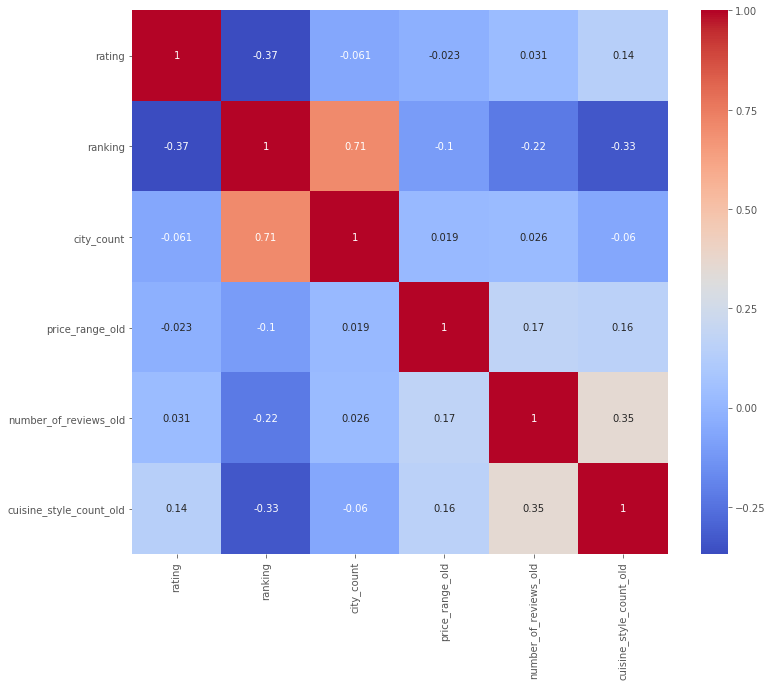

In [23]:
plt.rcParams['figure.figsize'] = (12, 10)
sns.heatmap(data_old.query('sample==1').copy().drop('sample', axis=1).corr(), annot=True, cmap='coolwarm')

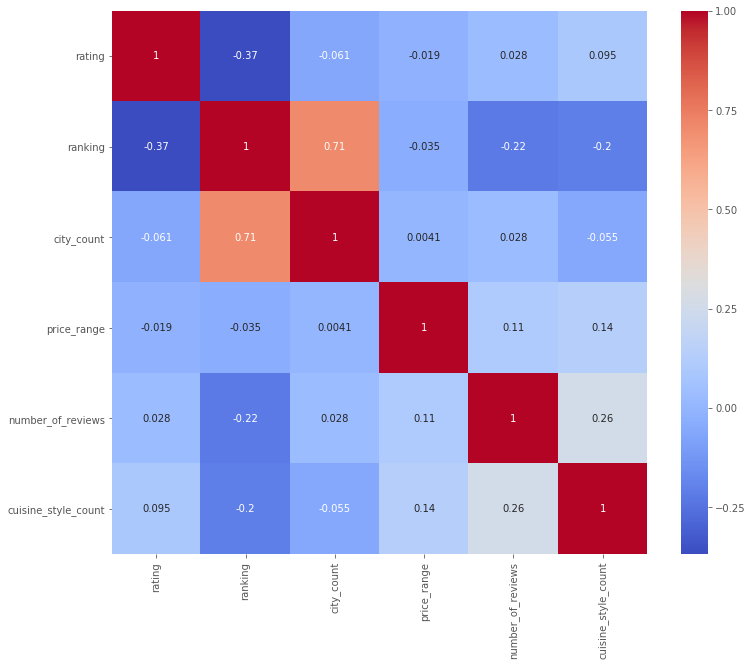

In [24]:
sns.heatmap(data_new.query('sample==1').copy().drop('sample', axis=1).corr(), annot=True, cmap='coolwarm')

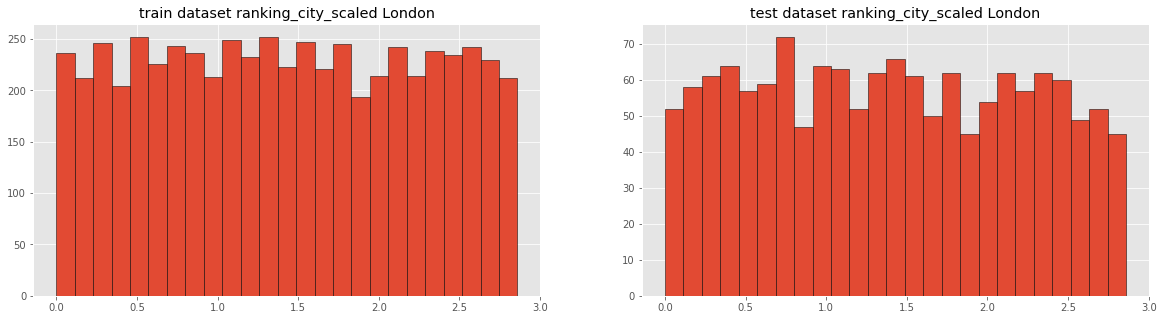

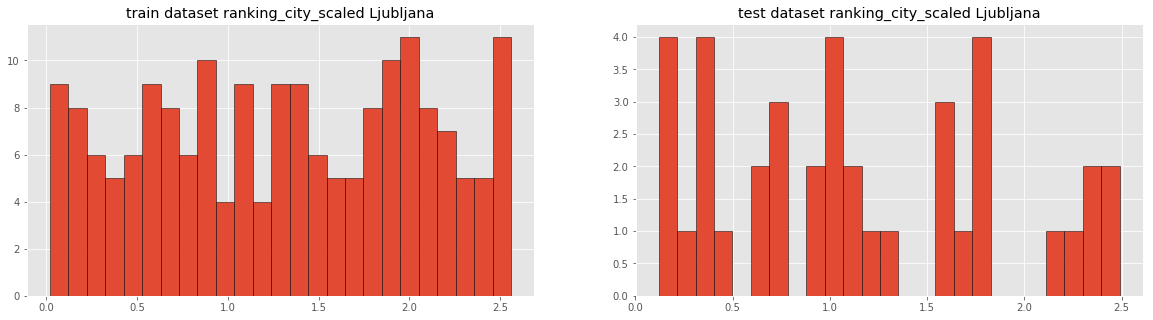

In [25]:
data['ranking_city_scaled'] = data.apply(lambda x: round(x['ranking']/x['city_count'], 2), axis=1)

for city in ['London', 'Ljubljana']:
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].hist(
            data.loc[(data['sample']==1)&(data['city']==city)]['ranking_city_scaled'],
            edgecolor="black", 
            bins=25
            )
    axes[1].hist(
            data.loc[(data['sample']==0)&(data['city']==city)]['ranking_city_scaled'],
            edgecolor="black", 
            bins=25
            )

    axes[0].set(title = 'train dataset ranking_city_scaled ' + city)
    axes[1].set(title = 'test dataset ranking_city_scaled ' + city)
    plt.show()

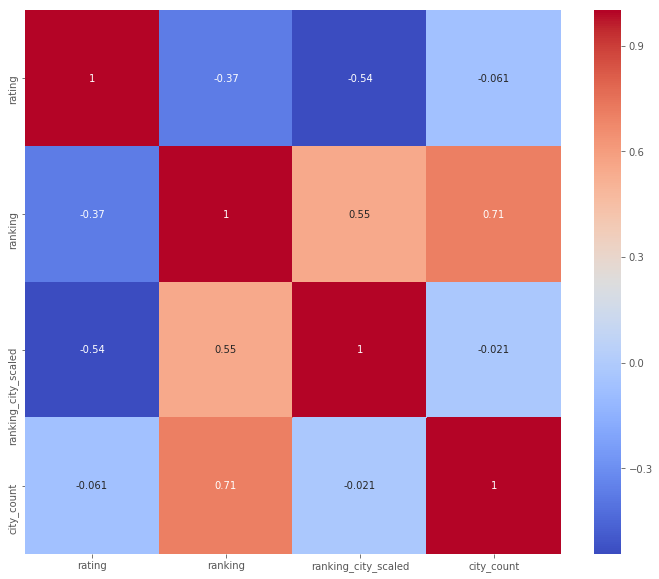

In [26]:
sns.heatmap(data.query('sample==1')[['sample', 'rating', 'ranking', 'ranking_city_scaled', 'city_count']].copy().drop('sample', axis=1).corr(), 
            annot=True, cmap='coolwarm')

## normalization

In [27]:
data_old.query('sample==1').describe()

sample        rating       ranking    city_count  price_range_old  \
count  40000.0  40000.000000  40000.000000  40000.000000     26114.000000   
mean       1.0      3.993037   3676.028525   2566.000000         2.221069   
std        0.0      0.668417   3708.749567   1862.235407         0.765395   
min        1.0      1.000000      1.000000    183.000000         1.000000   
25%        1.0      3.500000    973.000000    893.000000         2.500000   
50%        1.0      4.000000   2285.000000   2133.000000         2.500000   
75%        1.0      4.500000   5260.000000   4897.000000         2.500000   
max        1.0      5.000000  16444.000000   5757.000000         4.000000   

       number_of_reviews_old  cuisine_style_count_old  
count           37457.000000             30717.000000  
mean              124.825480                 3.112706  
std               295.666352                 1.806860  
min                 2.000000                 1.000000  
25%                 9.000000                 2.000000  
50%                33.000000                 3.000000  
75%               115.000000                 4.000000  
max              9660.000000                21.000000

Since we use ***max_features = n_features*** in the model parameters, it is recommended to normalize the data. We normalize the following features:
- ranking (logarithm first)
- number_of_reviews_old
- reviews_date_delta_old
- reviews_date_delta_max_old

In [28]:
def get_hists_df(df, col):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].hist(
            df.query('sample==1')[col],
            edgecolor="black", 
            bins=25
            )

    axes[1].hist(
            df.query('sample==0')[col],
            edgecolor="black", 
            bins=25
            )

    axes[0].set(title = 'train dataset ' + col)
    axes[1].set(title = 'test dataset ' + col)
    plt.show()

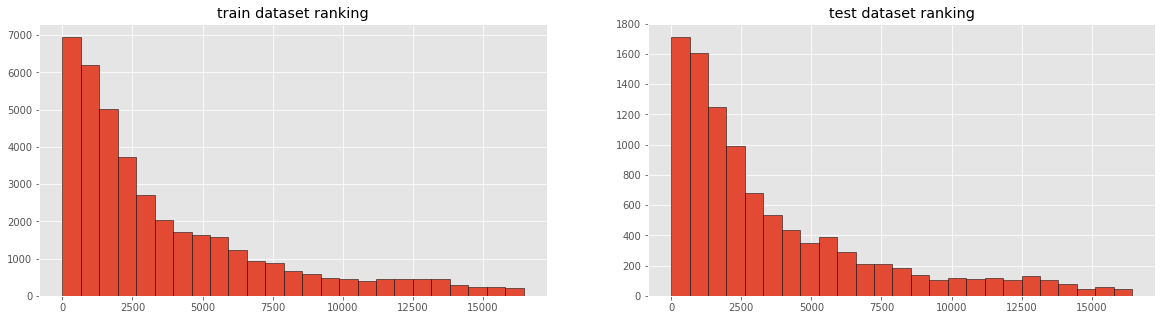

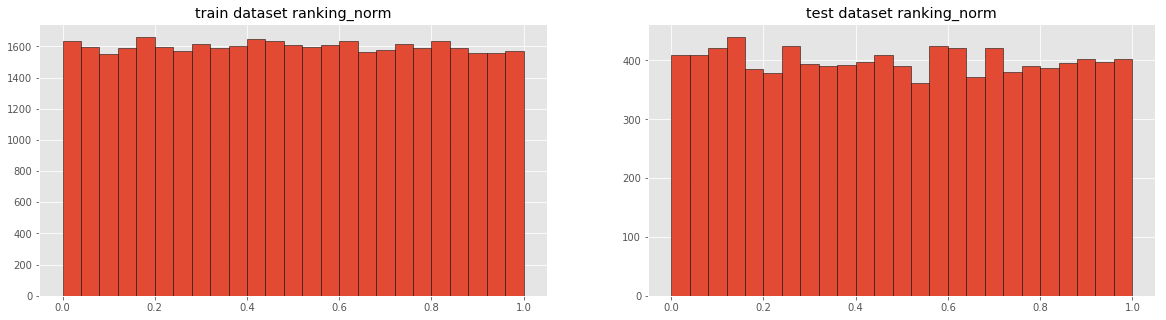

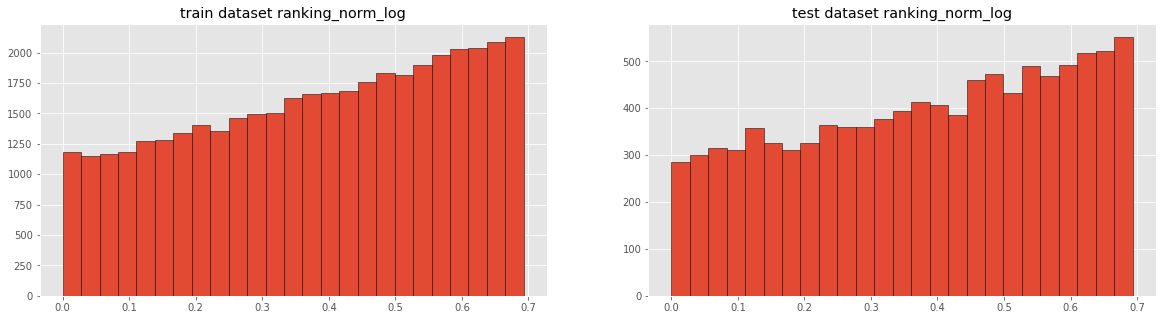

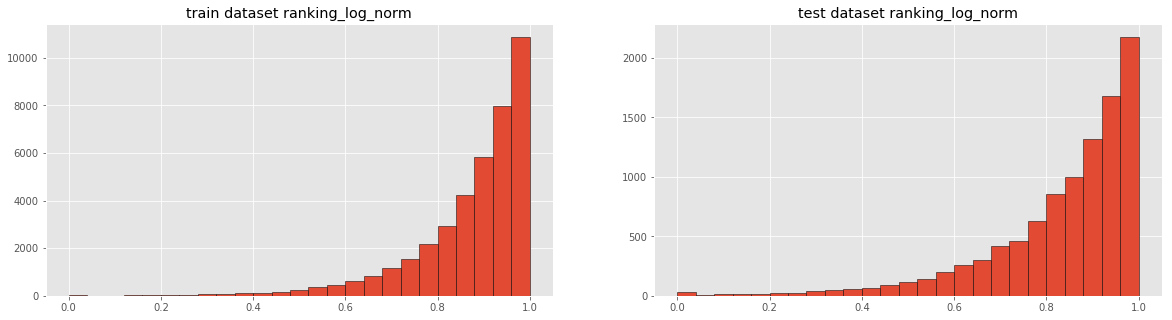

In [29]:
# since the samples are balanced, we can normalize ranking as follows: 
data['ranking_norm'] = data.groupby(['sample', 'city'])['ranking'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
data['ranking_norm_log'] = data['ranking_norm'].apply(lambda x: np.log(x+1))

data['ranking_log'] = data['ranking'].apply(lambda x: np.log(x))
data['ranking_log_norm'] = data.groupby(['sample', 'city'])['ranking_log'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

get_hists_df(data, 'ranking')
get_hists_df(data, 'ranking_norm')
get_hists_df(data, 'ranking_norm_log')
get_hists_df(data, 'ranking_log_norm')

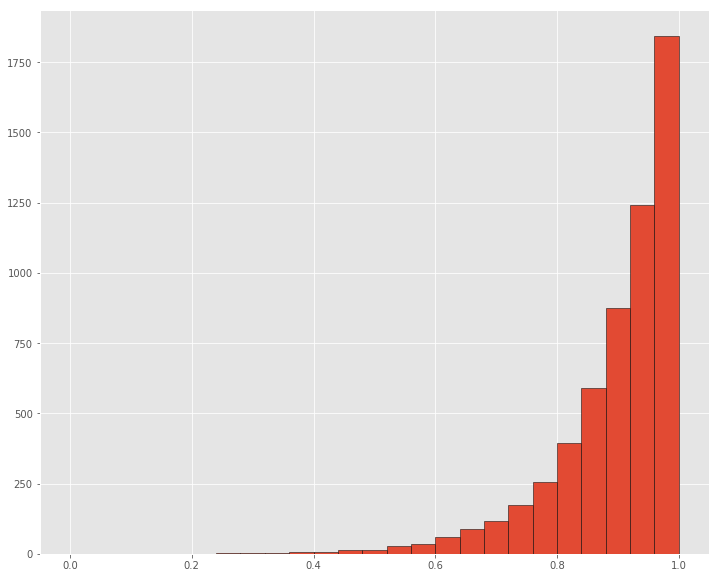

In [30]:
data[(data['sample']==1)&(data['city']=='London')]['ranking_log_norm'].hist(edgecolor="black", bins=25)

In [31]:
from sklearn.preprocessing import MinMaxScaler

for col in ['number_of_reviews_old', 'reviews_date_delta_old', 'reviews_date_delta_max_old']:
    scaler = MinMaxScaler()
    col_train = scaler.fit_transform(np.array(data.query('sample==1')[col]).reshape(-1, 1))
    col_test = scaler.transform(np.array(data.query('sample==0')[col]).reshape(-1, 1))
    
    indexes_test = pd.RangeIndex(start=0, stop=len(col_test))
    indexes_train = pd.RangeIndex(start=0, stop=len(col_train))

    new_col_df = pd.DataFrame(data=col_test, index=indexes_test, columns=[col+'_norm'])
    
    new_col_df = new_col_df.append(pd.DataFrame(data=col_train, index=indexes_train, columns=[col+'_norm']),
                                   sort=False).reset_index(drop=True)
    
    data = pd.concat([data, new_col_df], axis=1)

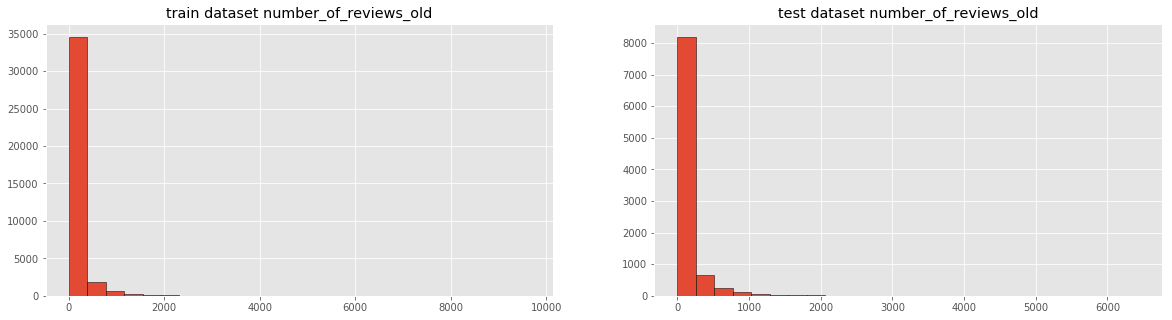

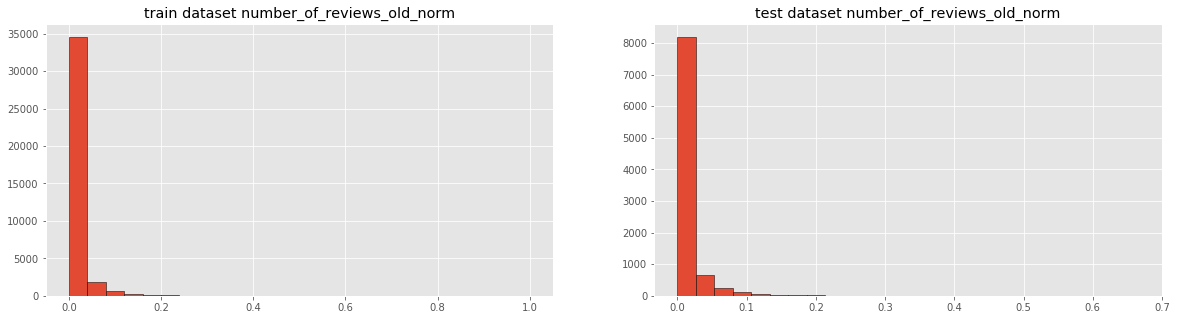

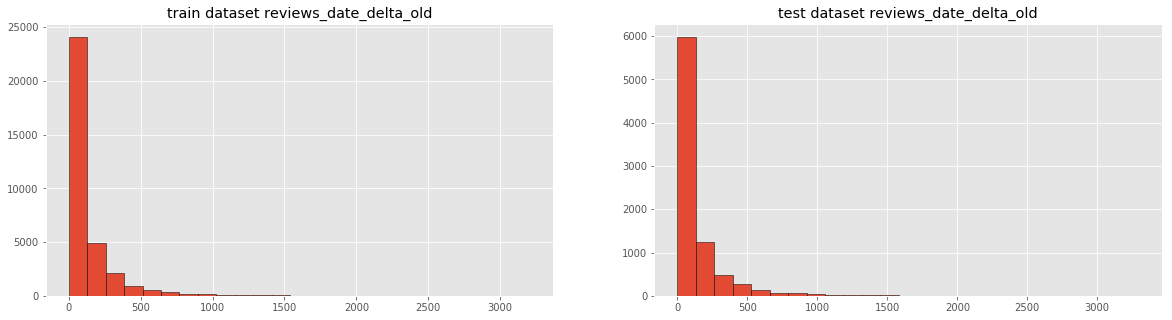

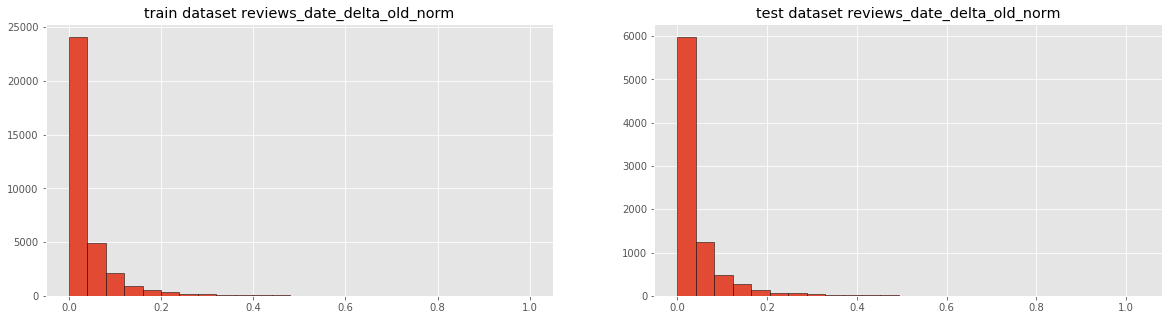

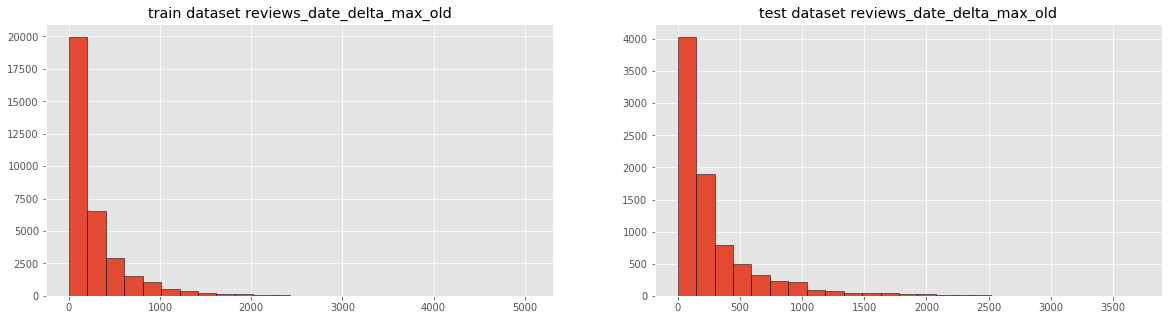

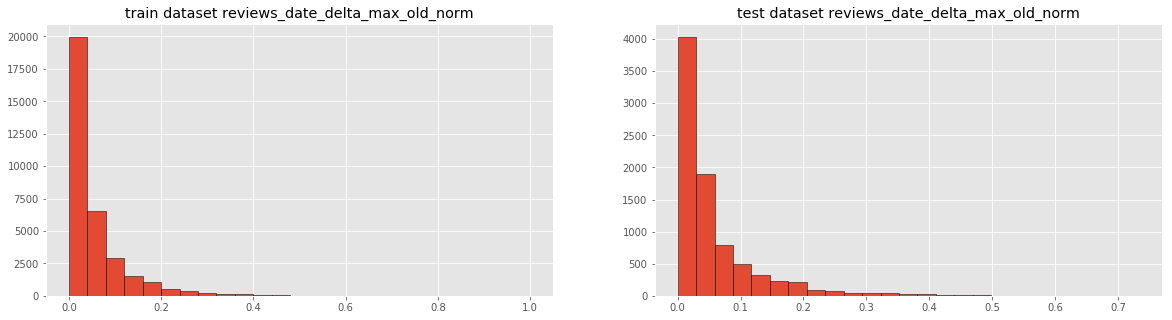

In [32]:
for col in ['number_of_reviews_old', 'number_of_reviews_old_norm', 'reviews_date_delta_old', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old', 'reviews_date_delta_max_old_norm']:
    get_hists_df(data, col)

In [33]:
data.drop('ranking_log', axis=1, inplace=True)
list(data.columns)[46:53]

['ranking_city_scaled',
 'ranking_norm',
 'ranking_norm_log',
 'ranking_log_norm',
 'number_of_reviews_old_norm',
 'reviews_date_delta_old_norm',
 'reviews_date_delta_max_old_norm']

In [34]:
features_dict.update({'norm_features': list(data.columns)[46:53]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features'
              ])

Data columns count: 53
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
Columns check: True


## First set of tests

In [35]:
                                    # first given columns with NaNs
models_dict = {'first_view_ranking': {'columns': get_data_columns_dict(['common_features', 'old_features']),
                                      'MAE': 0,
                                      'Train_r2_score': 0,
                                      'Test r2_score': 0,
                                      'nlargest': 0
                                      },
                                    # first given columns without NaNs
               'first_view_ranking_wo': {'columns': get_data_columns_dict(['common_features', 'new_features']),
                                         'MAE': 0,
                                         'Train_r2_score': 0,
                                         'Test r2_score': 0,
                                         'nlargest': 0
                                         },
                                     # ranking_city_scaled instead of ranking
               'first_view_rank_scl': {'columns': get_data_columns([remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['ranking']), ['ranking_city_scaled']]),
                                       'MAE': 0,
                                       'Train_r2_score': 0,
                                       'Test r2_score': 0,
                                       'nlargest': 0
                                       },
                                     # ranking without city_count
               'first_view_ranking_wo_cc': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['city_count']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # ranking_city_scaled without city_count
               'first_view_rank_scl_wo_cc': {'columns': get_data_columns([remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['ranking', 'city_count']), ['ranking_city_scaled']]),
                                             'MAE': 0,
                                             'Train_r2_score': 0,
                                             'Test r2_score': 0,
                                             'nlargest': 0
                                             },
                                     # ranking_norm instead of ranking
               'first_view_rank_norm': {'columns': get_data_columns([remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['ranking']), ['ranking_norm']]),
                                        'MAE': 0,
                                        'Train_r2_score': 0,
                                        'Test r2_score': 0,
                                        'nlargest': 0
                                        },
                                     # ranking_norm_log instead of ranking
               'first_view_rank_n_log': {'columns': get_data_columns([remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['ranking']), ['ranking_norm_log']]),
                                         'MAE': 0,
                                         'Train_r2_score': 0,
                                         'Test r2_score': 0,
                                         'nlargest': 0
                                         },
                                     # ranking_log_norm instead of ranking
               'first_view_rank_log_n': {'columns': get_data_columns([remove_elments(get_data_columns_dict(['common_features', 'old_features']), ['ranking']), ['ranking_log_norm']]),
                                         'MAE': 0,
                                         'Train_r2_score': 0,
                                         'Test r2_score': 0,
                                         'nlargest': 0
                                         },
                                     # + additional features with NaNs
               'add_features_old': {'columns': get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features']),
                                    'MAE': 0,
                                    'Train_r2_score': 0,
                                    'Test r2_score': 0,
                                    'nlargest': 0
                                    },
                                     # + additional features without NaNs
               'add_features_new': {'columns': get_data_columns_dict(['common_features', 'new_features', 'add_com_features', 'add_new_features']),
                                    'MAE': 0,
                                    'Train_r2_score': 0,
                                    'Test r2_score': 0,
                                    'nlargest': 0
                                    },
              }


In [36]:
for model_name in models_dict.keys():
    print(model_name)
    model_tests(model_name)

first_view_ranking


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_ranking_wo


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_rank_scl


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_ranking_wo_cc


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_rank_scl_wo_cc


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_rank_norm


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_rank_n_log


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


first_view_rank_log_n


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_features_old


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_features_new


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [37]:
models_df_1 = pd.DataFrame.from_dict(models_dict, orient='index')
models_df_1
# models_df_1.loc['first_view_ranking']['nlargest']

columns  \
first_view_ranking         [sample, rating, city, cuisine_style, ranking,...   
first_view_ranking_wo      [sample, rating, city, cuisine_style, ranking,...   
first_view_rank_scl        [sample, rating, city, cuisine_style, city_cou...   
first_view_ranking_wo_cc   [sample, rating, city, cuisine_style, ranking,...   
first_view_rank_scl_wo_cc  [sample, rating, city, cuisine_style, price_ra...   
first_view_rank_norm       [sample, rating, city, cuisine_style, city_cou...   
first_view_rank_n_log      [sample, rating, city, cuisine_style, city_cou...   
first_view_rank_log_n      [sample, rating, city, cuisine_style, city_cou...   
add_features_old           [sample, rating, city, cuisine_style, ranking,...   
add_features_new           [sample, rating, city, cuisine_style, ranking,...   

                                MAE  Train_r2_score  Test r2_score  \
first_view_ranking         0.211712        0.969294       0.775145   
first_view_ranking_wo      0.223051        0.967054       0.752034   
first_view_rank_scl        0.216355        0.964866       0.770943   
first_view_ranking_wo_cc   0.405017        0.891186       0.255503   
first_view_rank_scl_wo_cc  0.277344        0.895534       0.644955   
first_view_rank_norm       0.215019        0.968643       0.780040   
first_view_rank_n_log      0.214888        0.968642       0.780266   
first_view_rank_log_n      0.213499        0.969252       0.781111   
add_features_old           0.207568        0.970733       0.782424   
add_features_new           0.219269        0.968460       0.763024   

                                                                    nlargest  
first_view_ranking         ranking                    0.528484
city_count...  
first_view_ranking_wo      ranking                0.542849
city_count    ...  
first_view_rank_scl        ranking_city_scaled        0.645799
number_of_...  
first_view_ranking_wo_cc   ranking                    0.667834
number_of_...  
first_view_rank_scl_wo_cc  ranking_city_scaled        0.704091
number_of_...  
first_view_rank_norm       ranking_norm               0.676704
number_of_...  
first_view_rank_n_log      ranking_norm_log           0.676708
number_of_...  
first_view_rank_log_n      ranking_log_norm           0.661419
number_of_...  
add_features_old           ranking                       0.490143
city_co...  
add_features_new           ranking                   0.493755
city_count ...

**First set of test**:
1. Taking the initially provided data without filling up the gaps and adding to them the number of restaurants in the city and the number of kitchens in the restaurant gave the same result as baseline (even slightly better: 0.2124 vs 0.2118 MAE).
2. The 3 most important features stood out: **ranking, city_count, number_of_reviews_old**, and **ranking** takes about 50%.
3. Despite the fact that **city_count** is strongly correlated with **ranking**, this feature greatly improves the accuracy of training (0.212 vs 0.405 MAE). Together, these two parameters work better than when scaling **ranking** by city (0.212 vs 0.227 MAE).
4. There is uderfitting of the model, since on the cross validation graph the train and test scores lines run parallel to each other.
5. Tests with normalization and logarithm **ranking** did not lead to improved results.
6. Filling up the gaps led to an increase in the error (0.212 vs 0.223 MAE). Most likely, because by the presence of omissions, the samples are also balanced and the better way of filling up hasn't been found.
7. Adding new features reduces the error, but does not correct the situation with the uderfitting, since there are no new significant features.


## statistics

In [38]:
data_num = data[get_data_columns([get_data_columns_dict(['common_features', 'new_features', 'add_com_features', 'add_new_features']), ['gcode_count']])].copy().select_dtypes(include='number')
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
sample                    50000 non-null int64
rating                    50000 non-null float64
ranking                   50000 non-null float64
city_count                50000 non-null int64
price_range               50000 non-null float64
number_of_reviews         50000 non-null float64
cuisine_style_count       50000 non-null float64
chain                     50000 non-null int64
chain_scale               50000 non-null int64
name_city_count           50000 non-null int64
rest_type_count           50000 non-null float64
area_food_count           50000 non-null float64
country_food_count        50000 non-null float64
spcialities_count         50000 non-null float64
reviews_date_delta        50000 non-null float64
reviews_date_delta_max    50000 non-null float64
gcode_count               50000 non-null int64
dtypes: float64(11), int64(6)
memory usage: 6.5 MB


In [39]:
def get_plots(col):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].plot(data_num.query('sample==1')[col],
            lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
            marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
            markersize=1
            )
    
    axes[1].plot(data_num.query('sample==0')[col],
            lw=0,                            # lw stands for line width. 0 means that we don't want to show any lines
            marker=".",                      # Instead of lines, we tell the plot to use . as markers for each data point
            markersize=1
            )
    
    axes[0].set(title = 'train dataset ' + col)
    axes[1].set(title = 'test dataset ' + col)
    plt.show()


def get_hists(col):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))

    axes[0].hist(
            data_num.query('sample==1')[col],
            edgecolor="black", 
            bins=25
            )

    axes[1].hist(
            data_num.query('sample==0')[col],
            edgecolor="black", 
            bins=25
            )

    axes[0].set(title = 'train dataset ' + col)
    axes[1].set(title = 'test dataset ' + col)
    plt.show()
    
    
def get_regplots(col, cols):
    fig, axes = plt.subplots(ncols=len(cols)//2+1, nrows=2, figsize=(20, 5))
    
    for c, ax in zip(cols, axes.ravel()):
        
        sns.regplot(x=data_num.query('sample==1')[c],
                    y=data_num.query('sample==1')[col],
                    line_kws={"color":"g","alpha":0.7,"lw":5},
                    ax=ax
                   )
    plt.tight_layout()
    plt.show()
    
    
def get_charts(col):
    cols = list(data_num.columns)
    cols.remove(col)
    try:
        cols.remove('sample')
    except: pass
    
    if col not in ['sample']:
        get_plots(col)
        get_hists(col)
        get_regplots(col, cols)

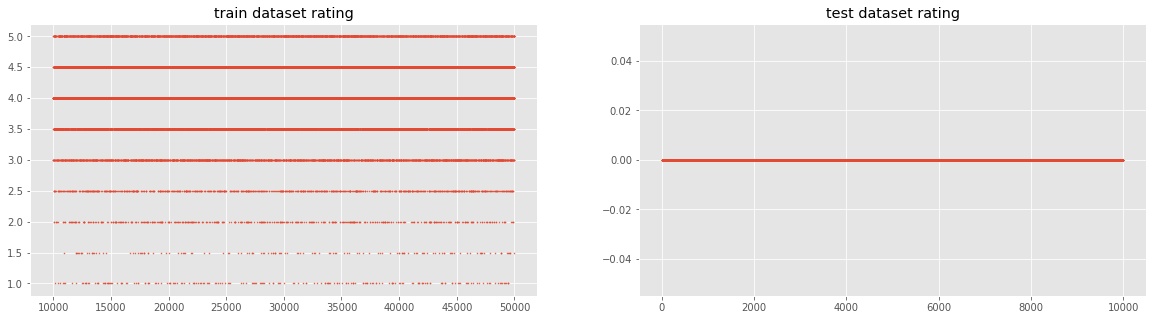

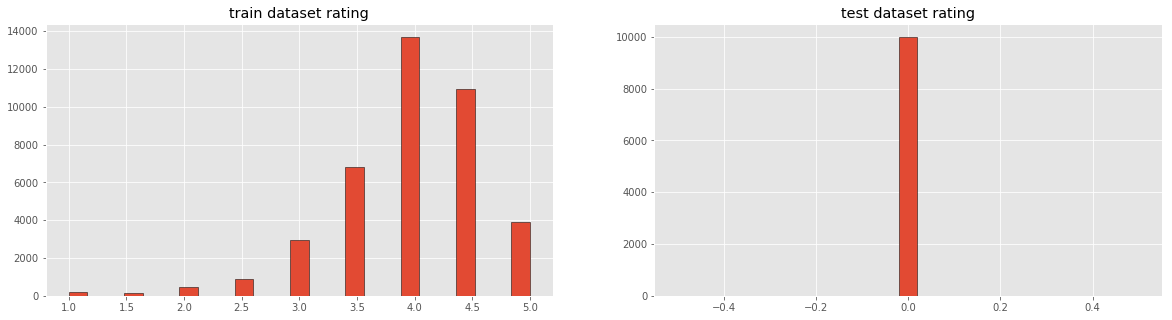

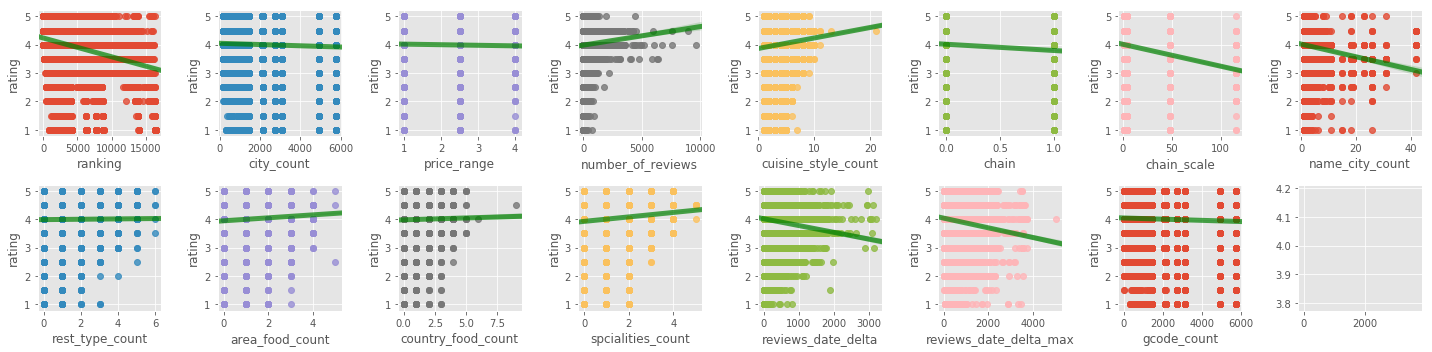

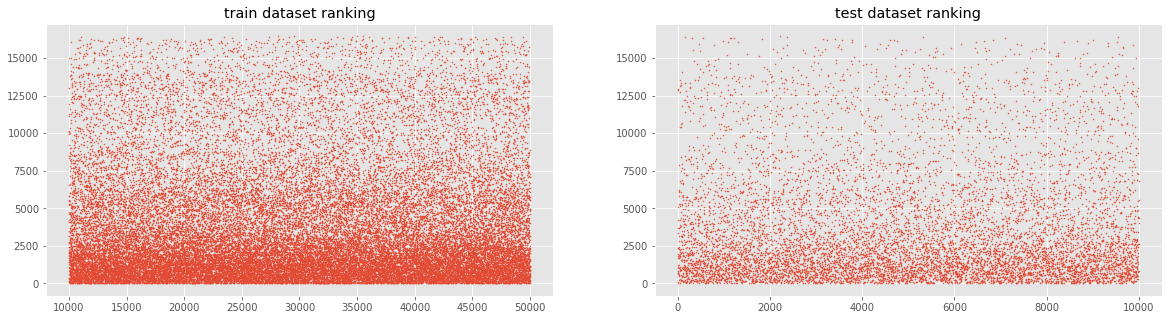

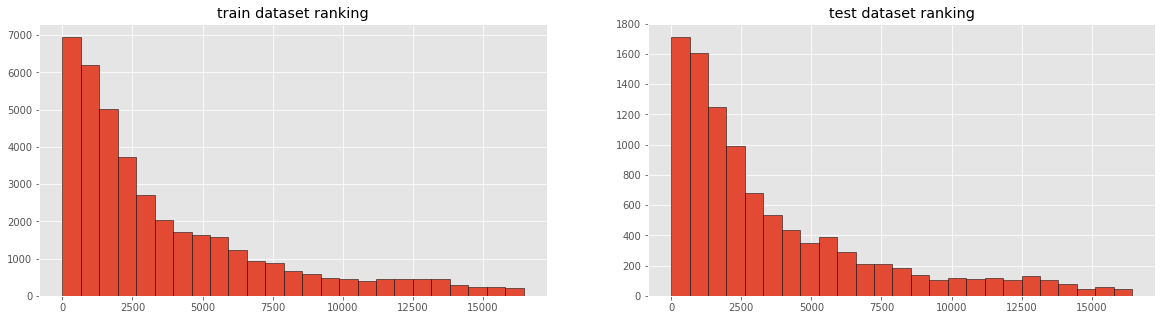

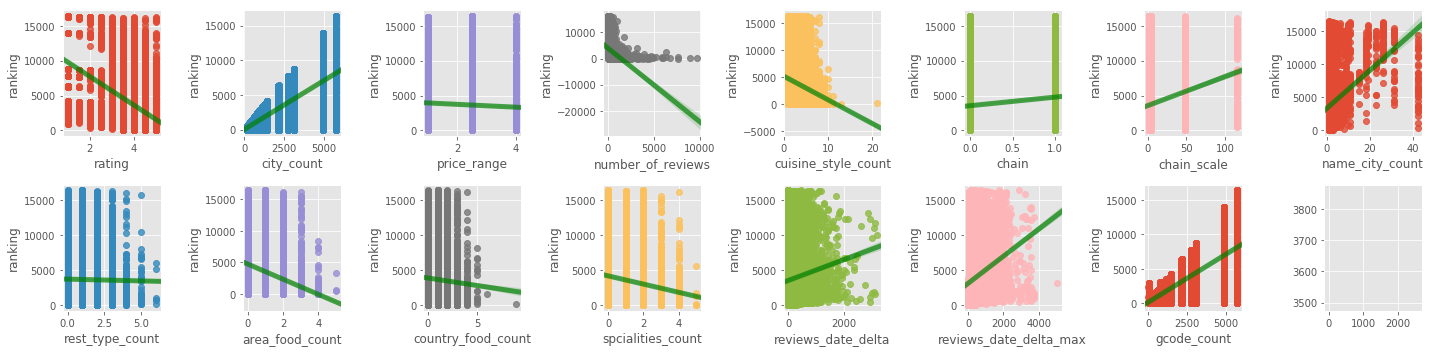

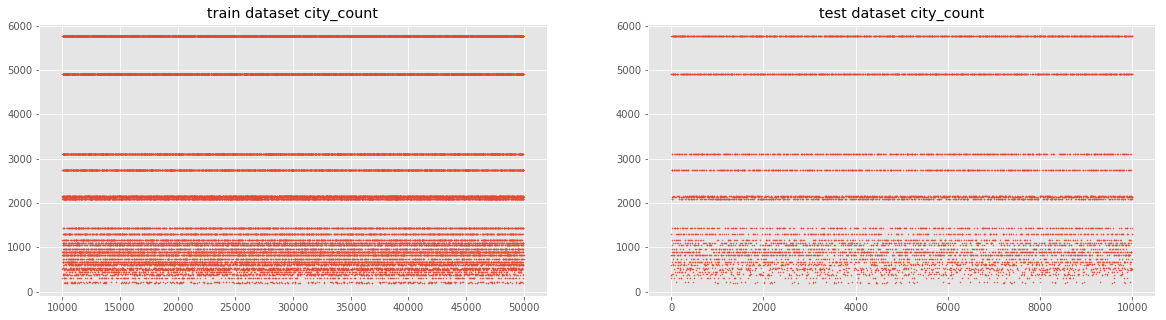

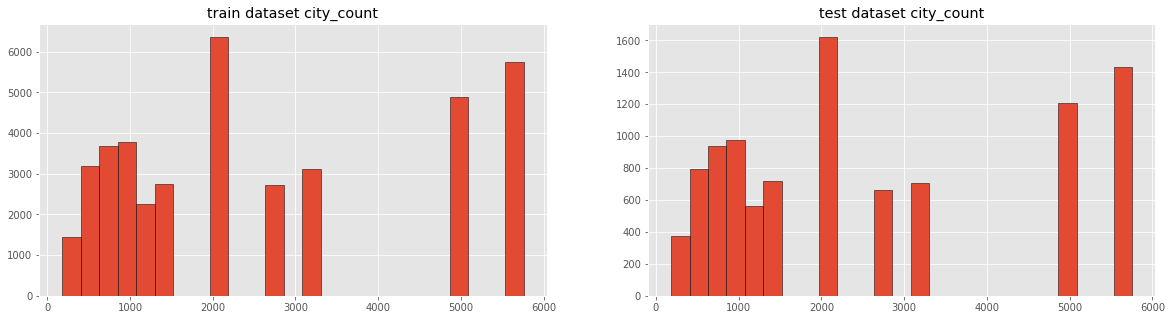

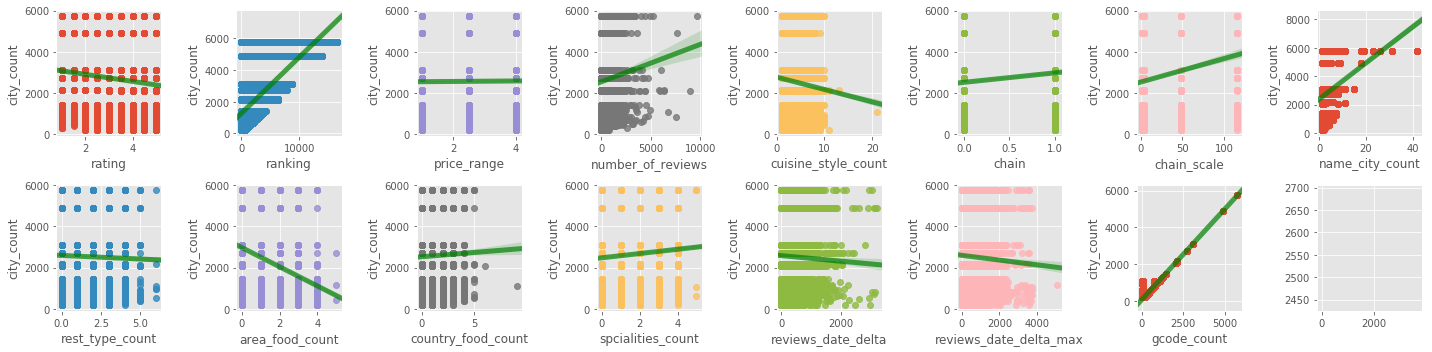

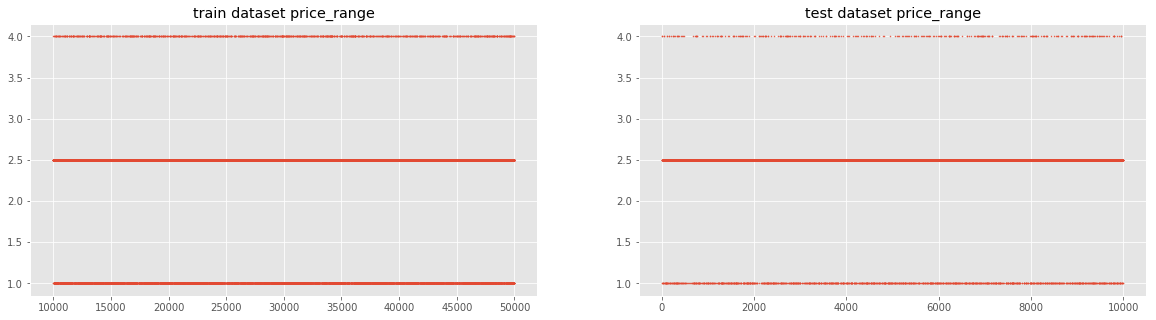

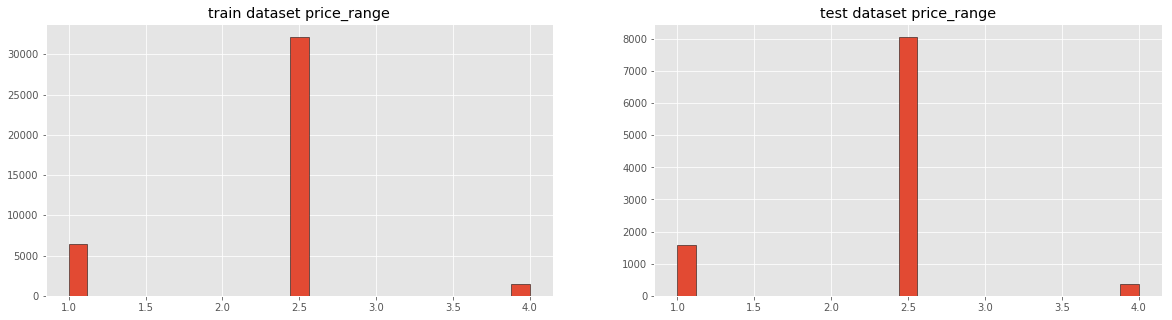

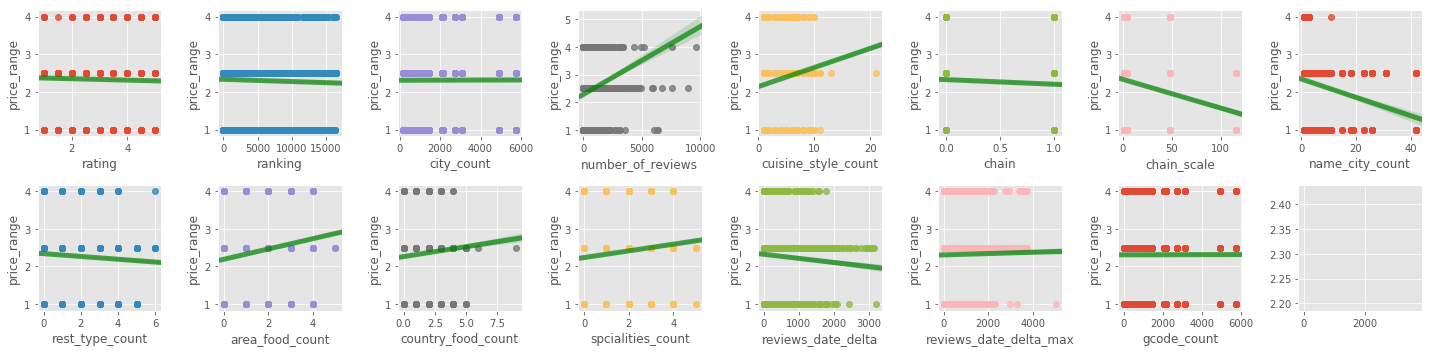

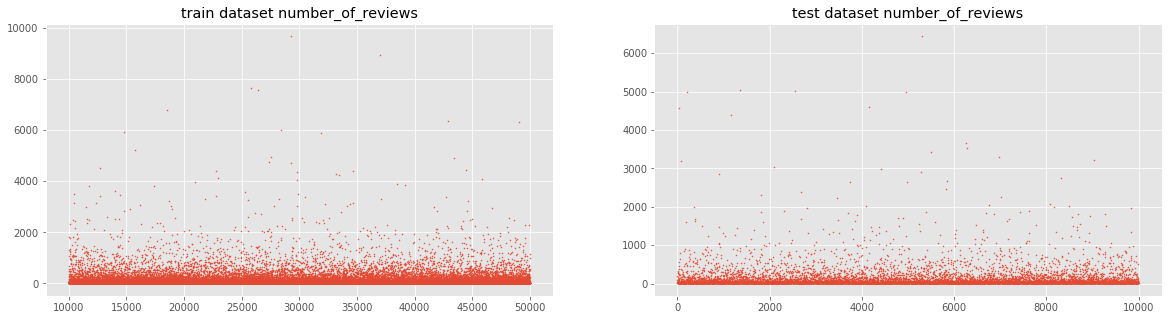

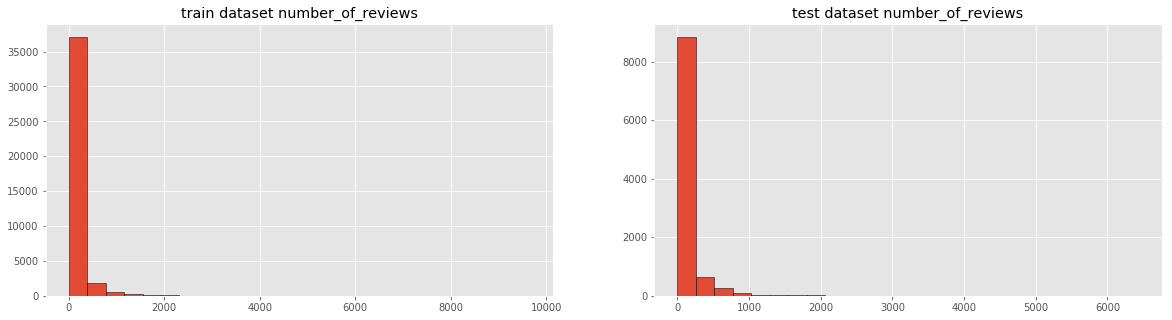

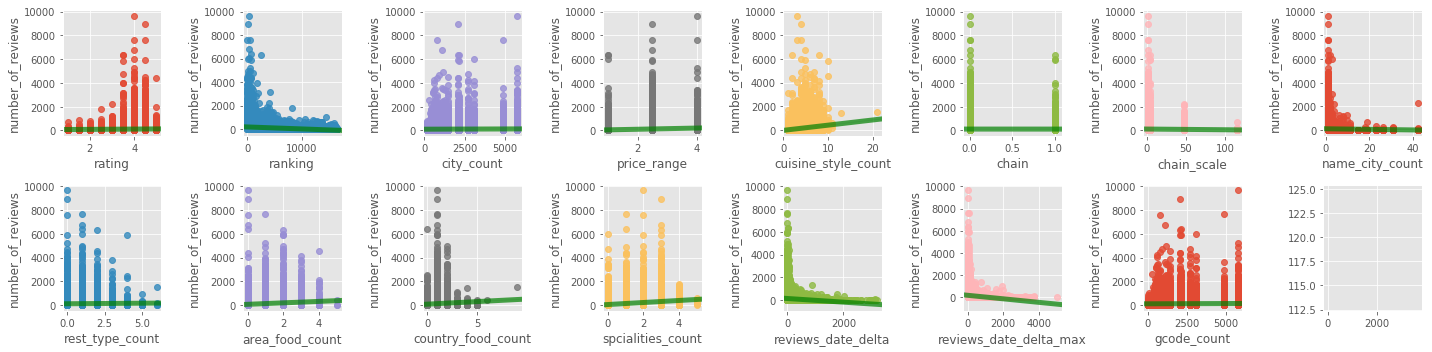

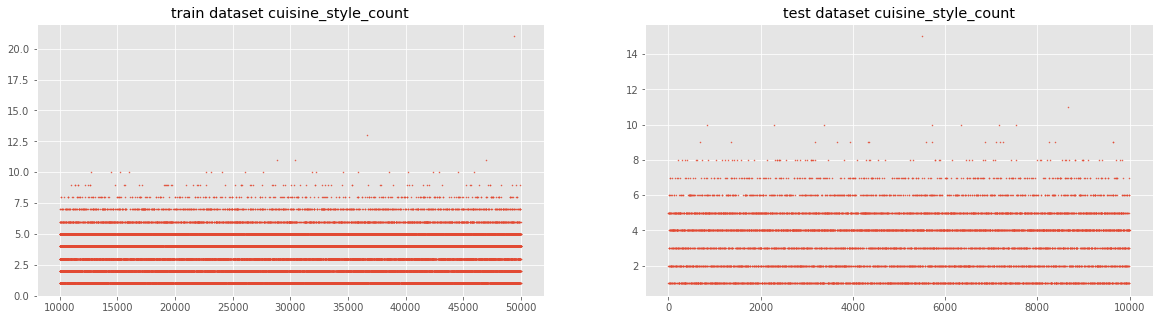

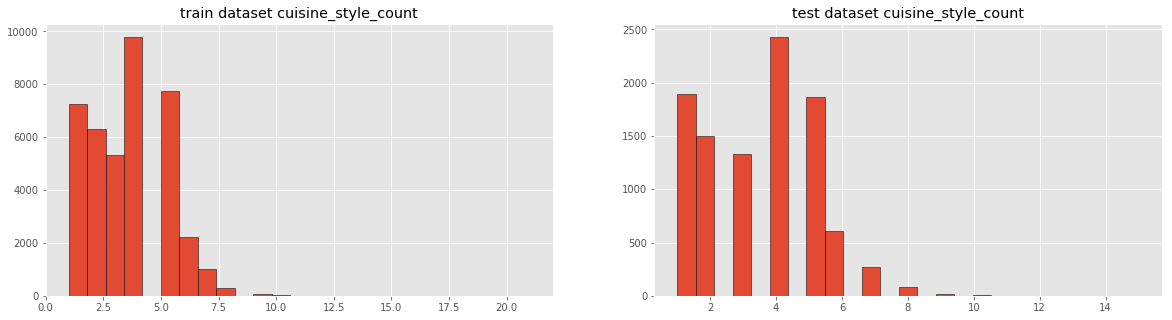

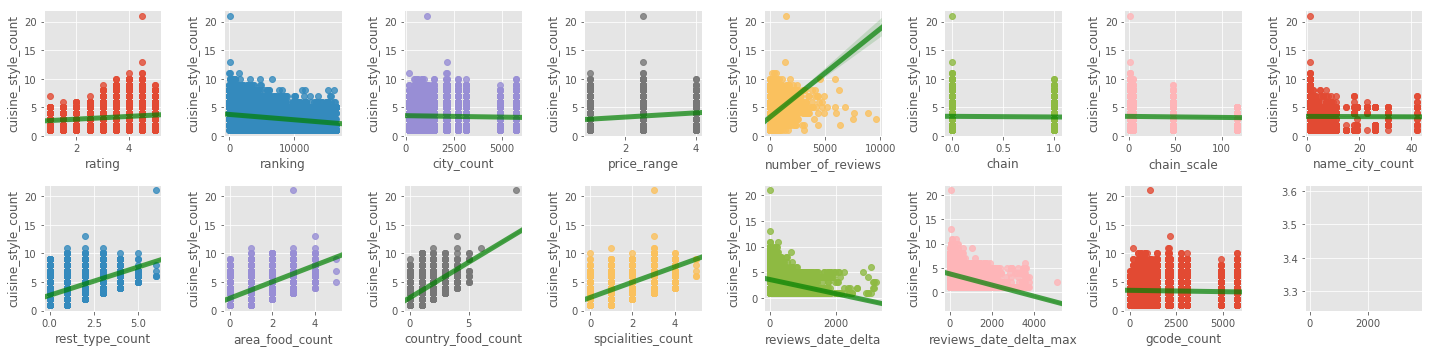

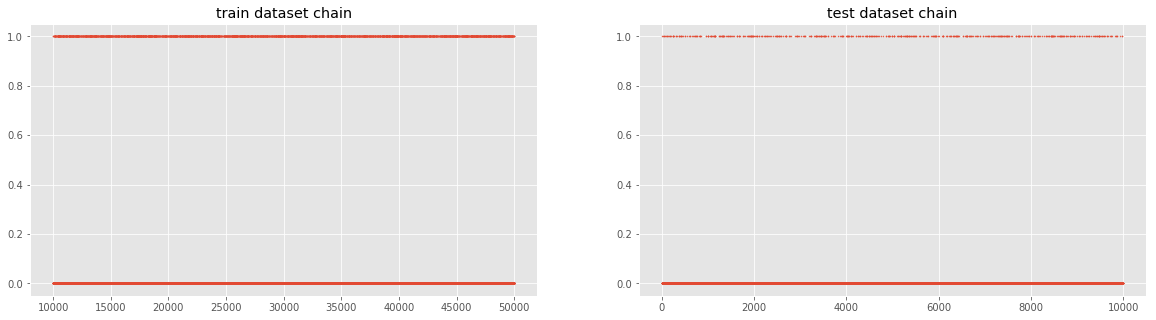

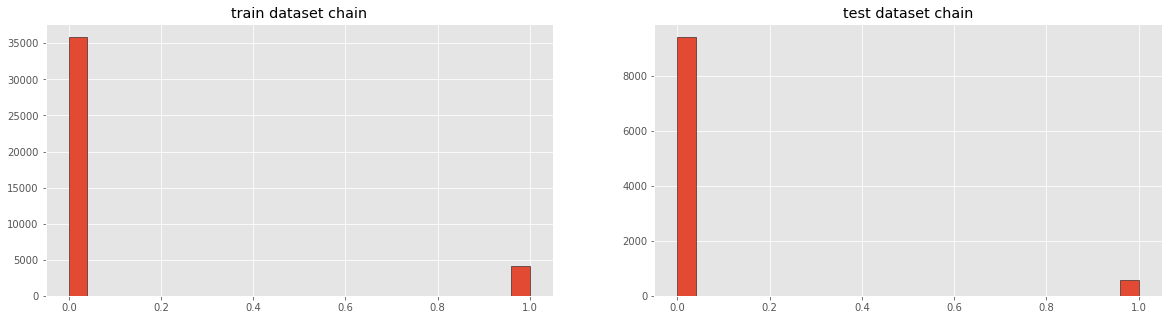

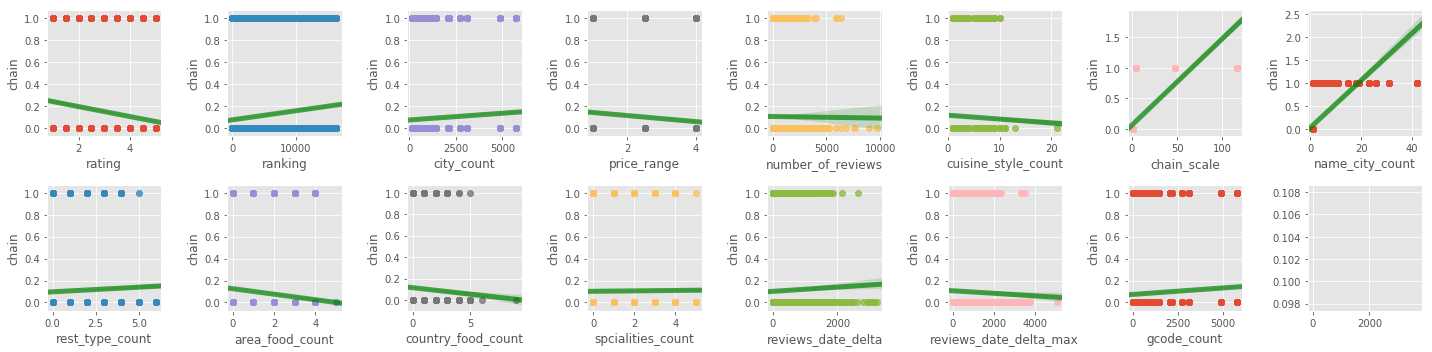

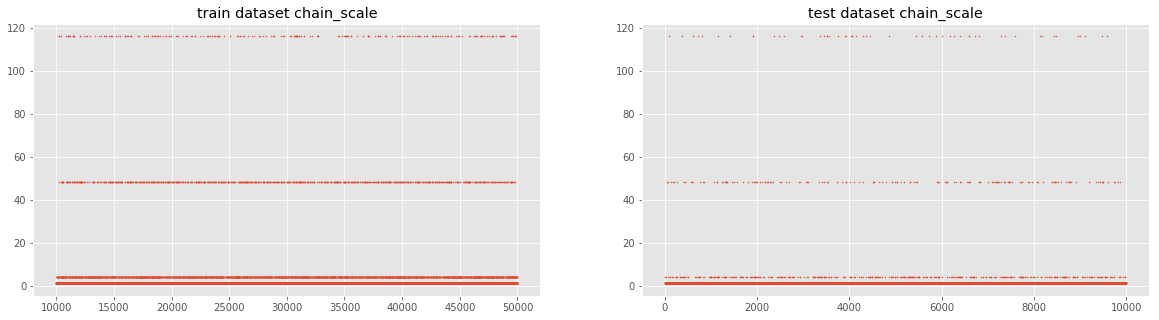

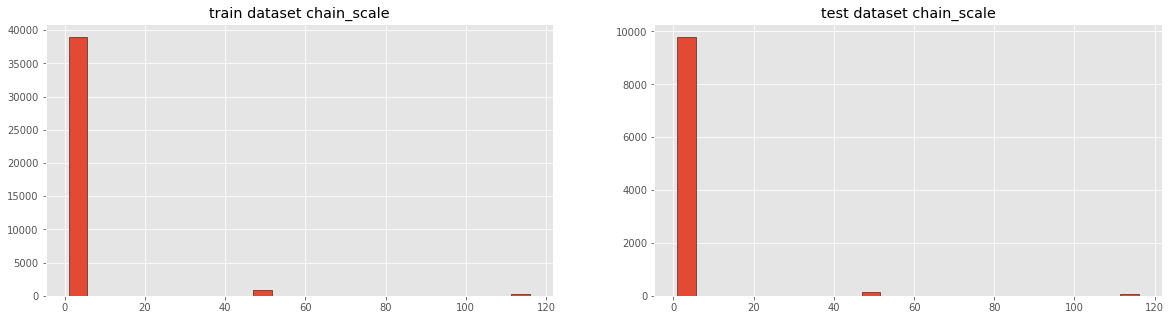

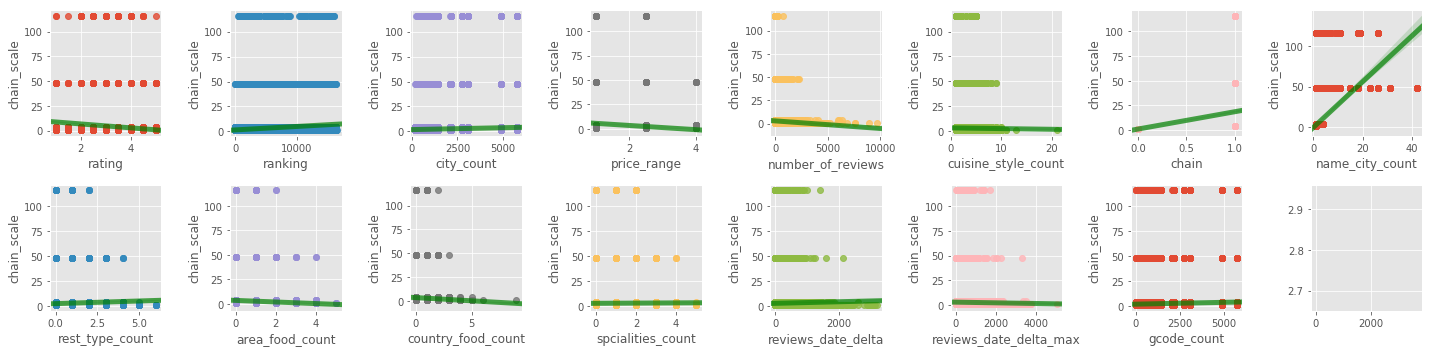

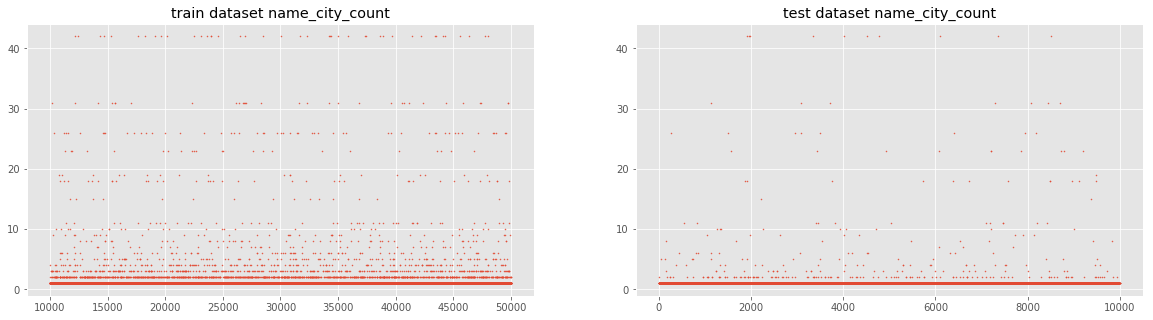

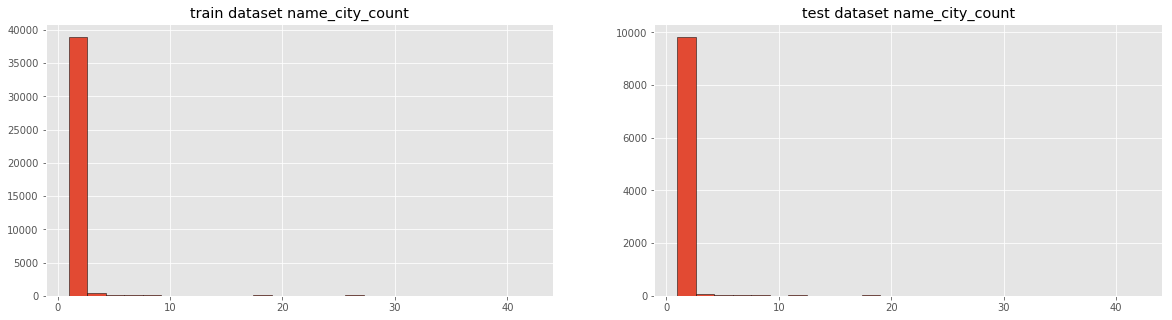

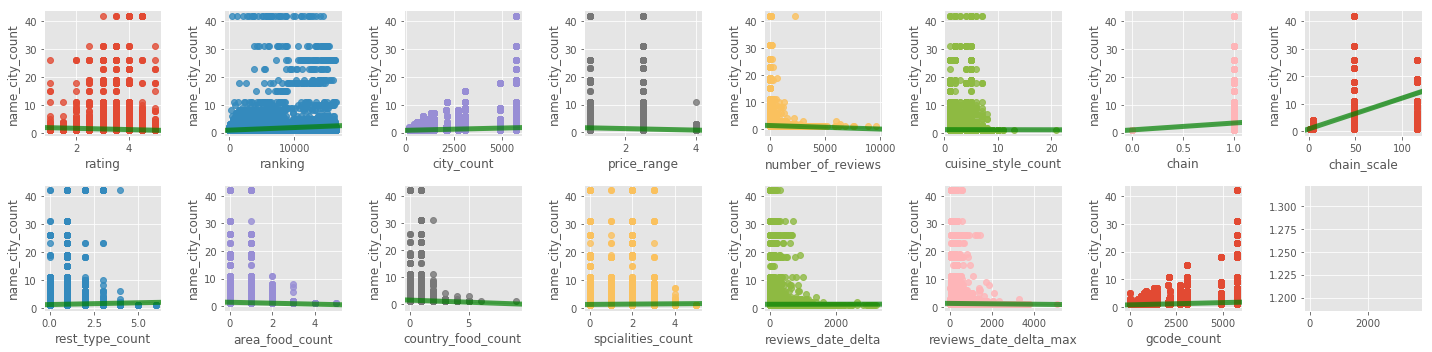

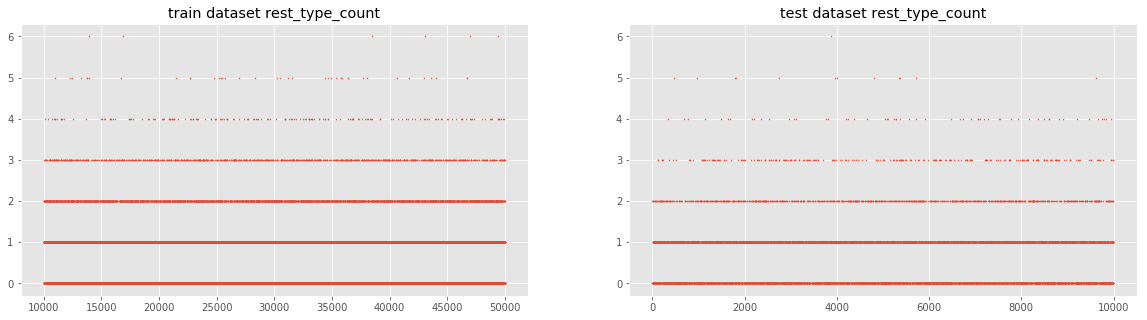

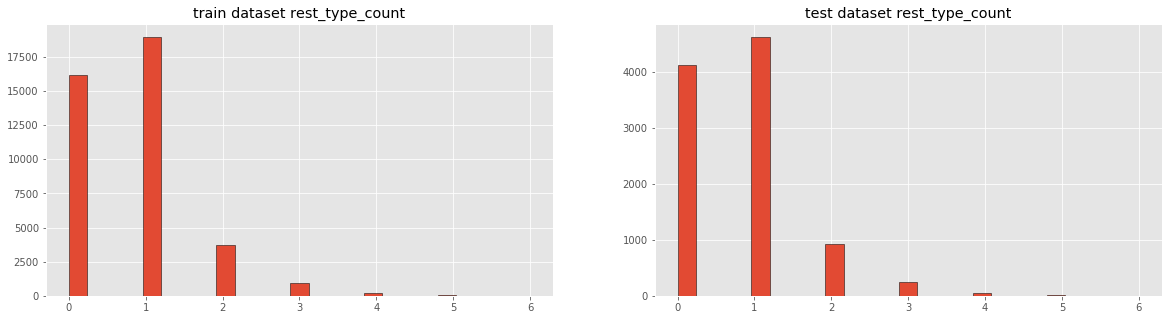

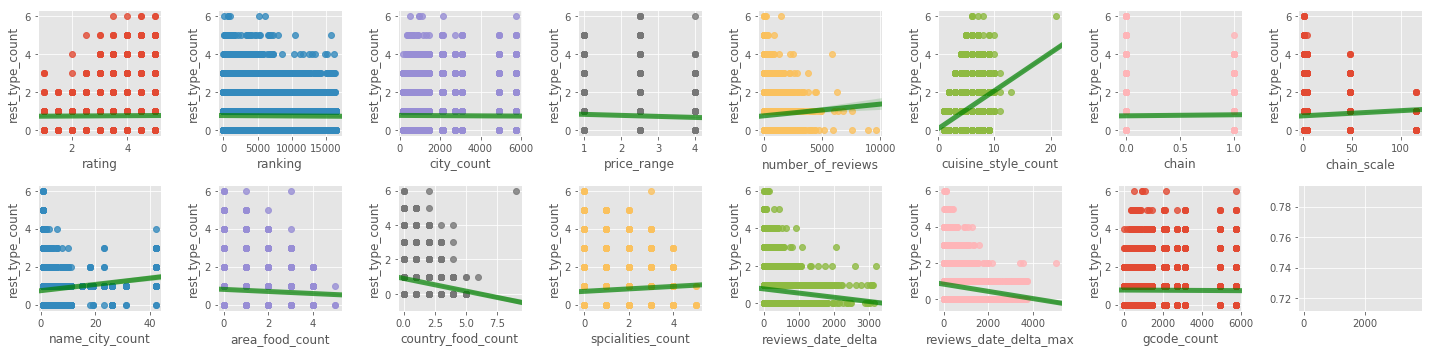

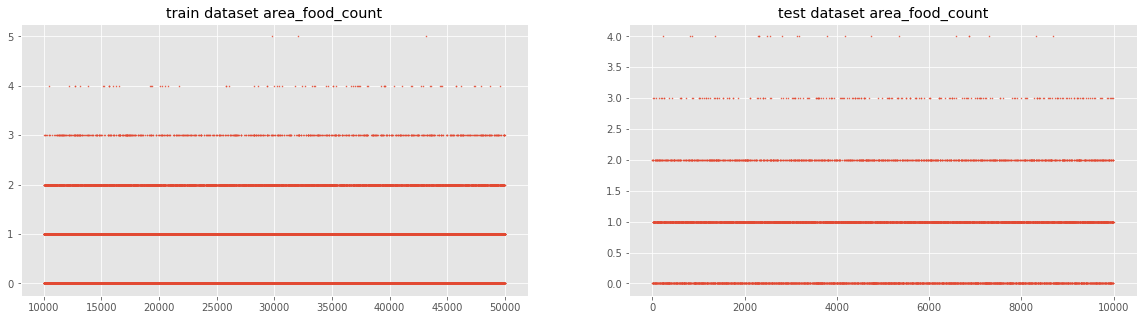

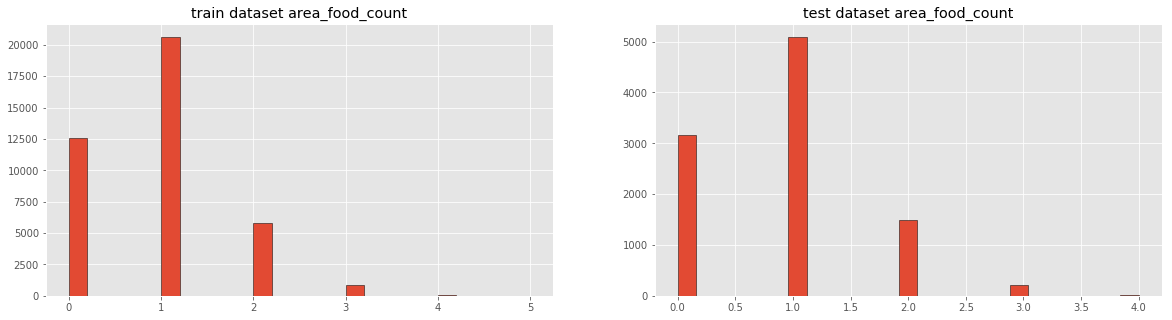

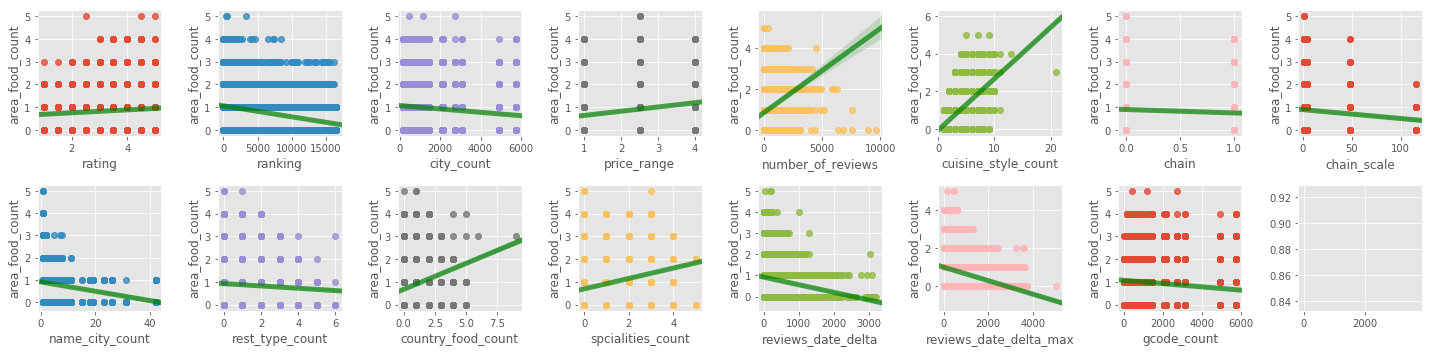

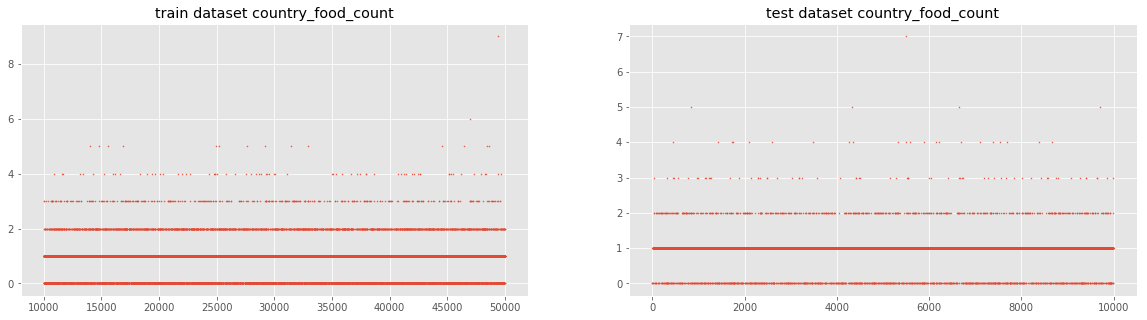

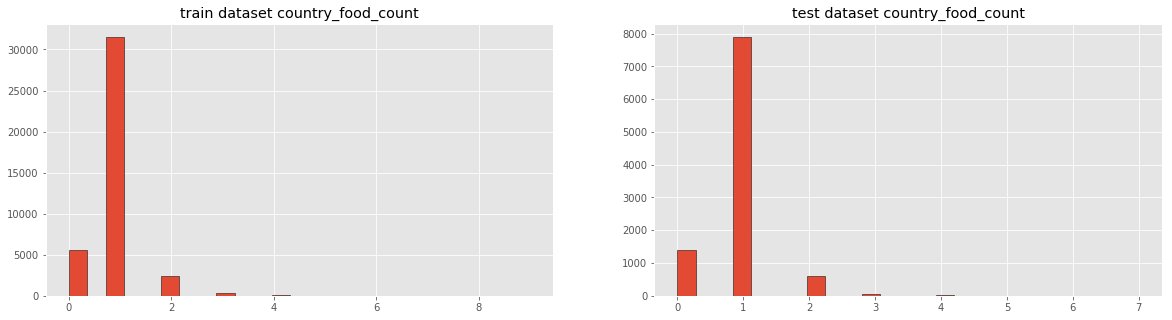

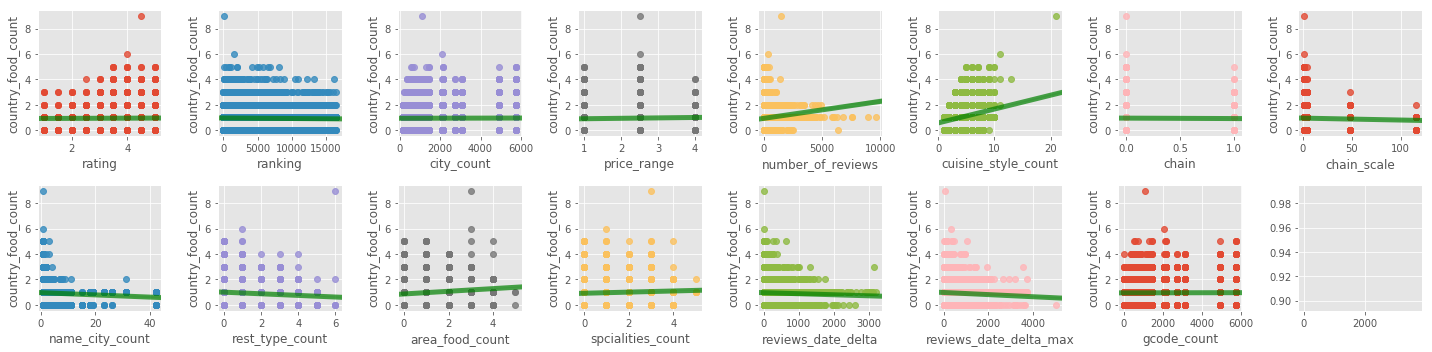

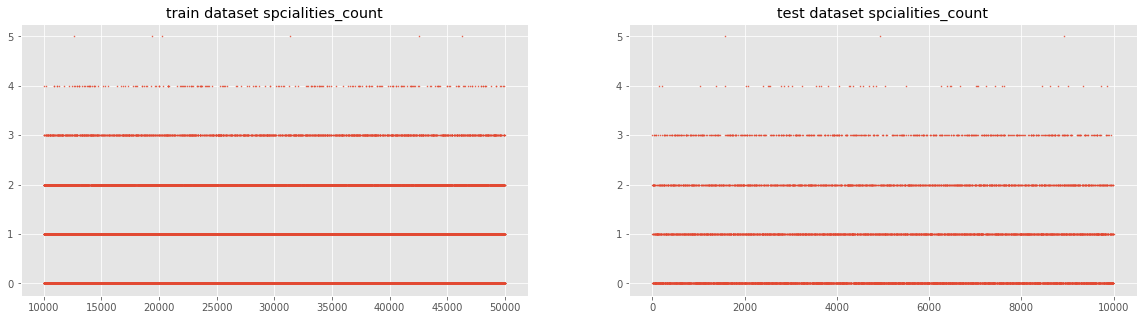

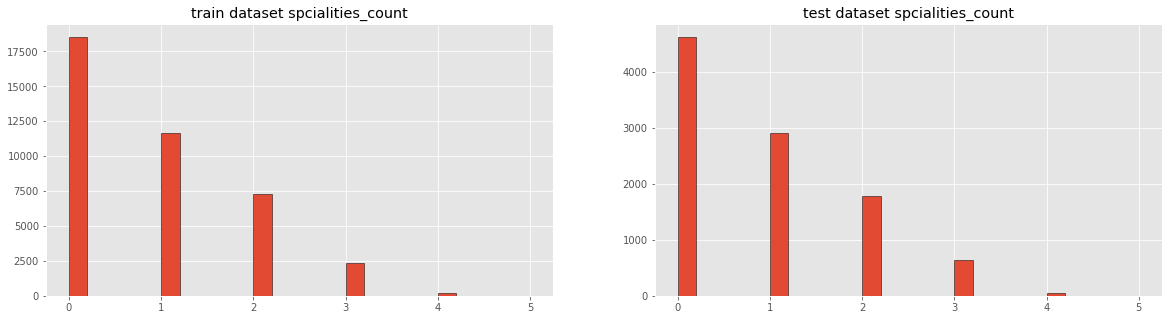

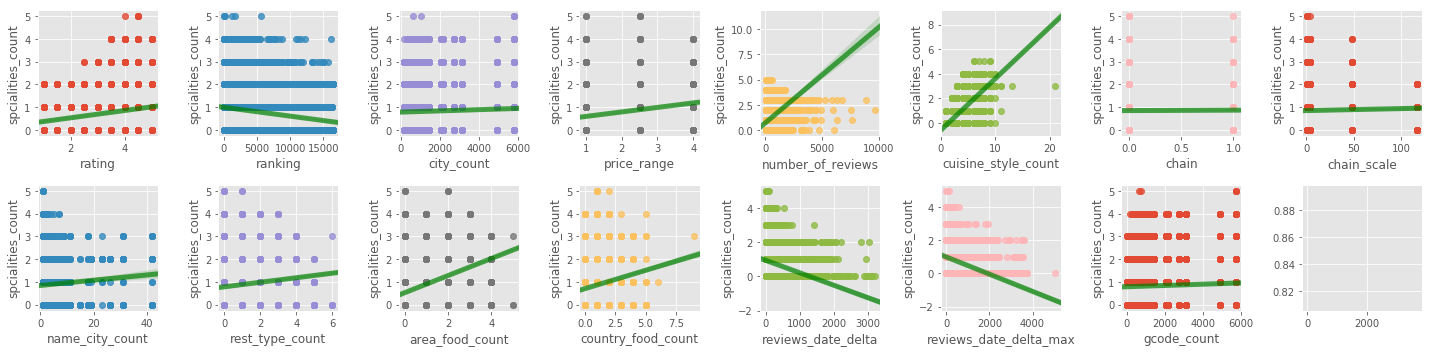

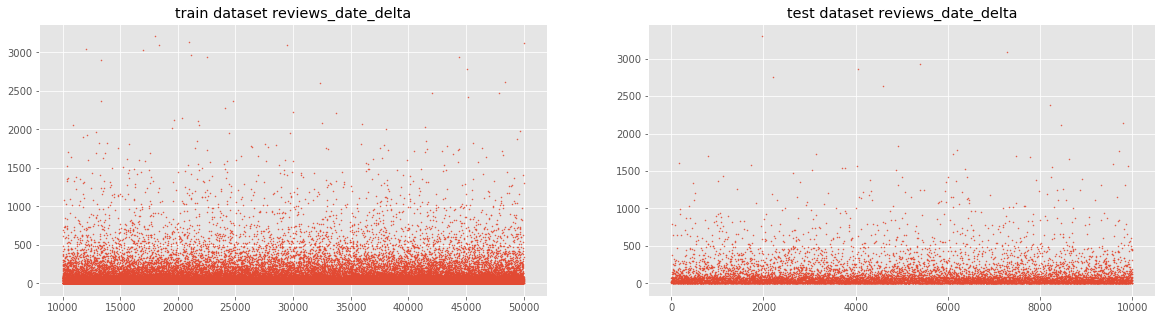

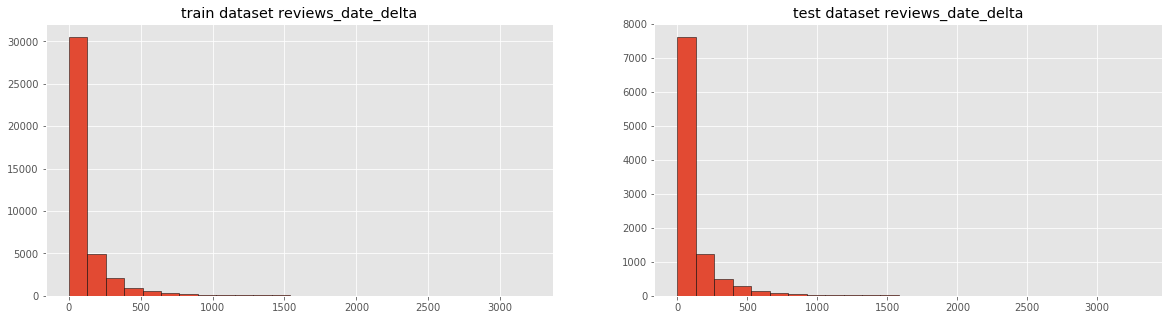

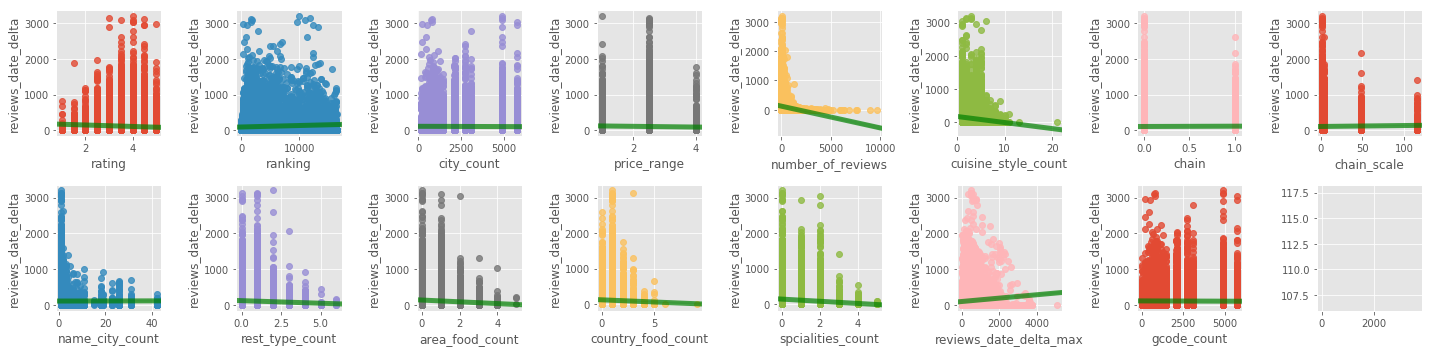

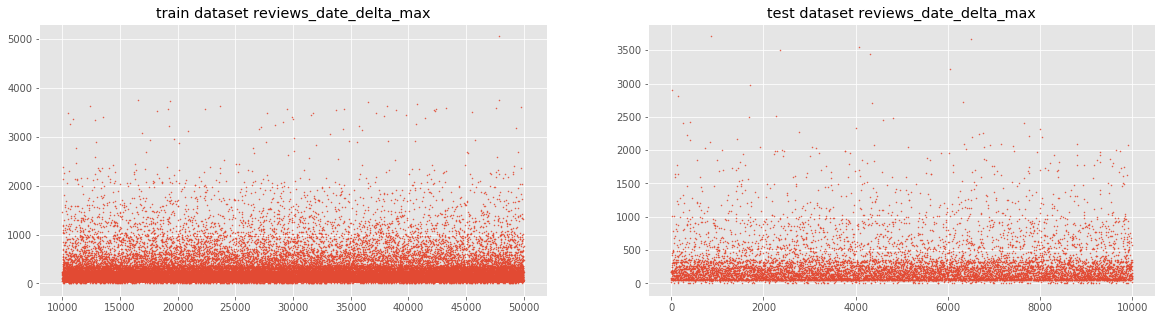

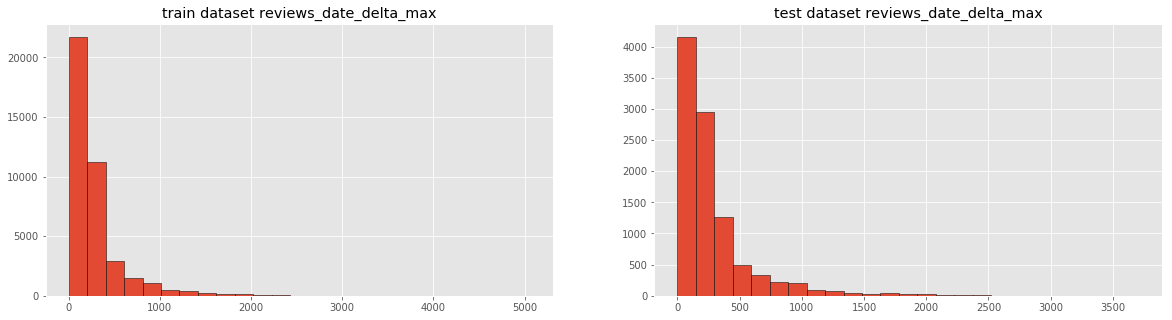

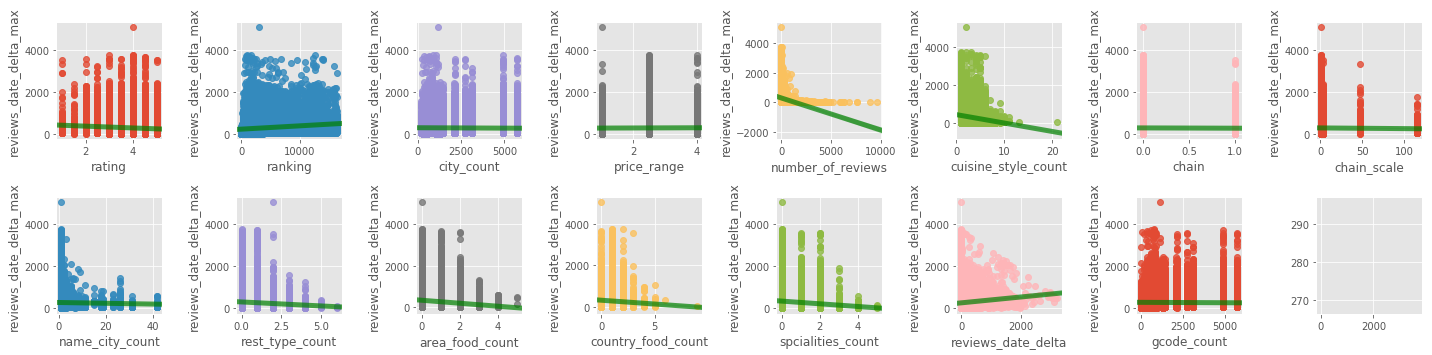

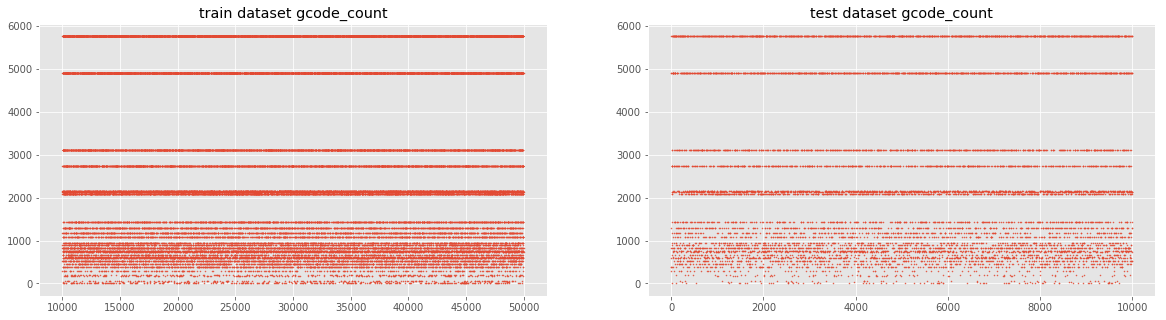

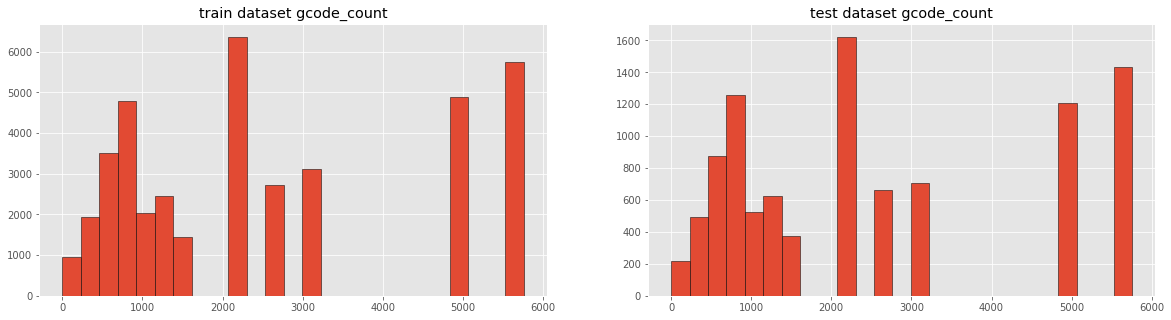

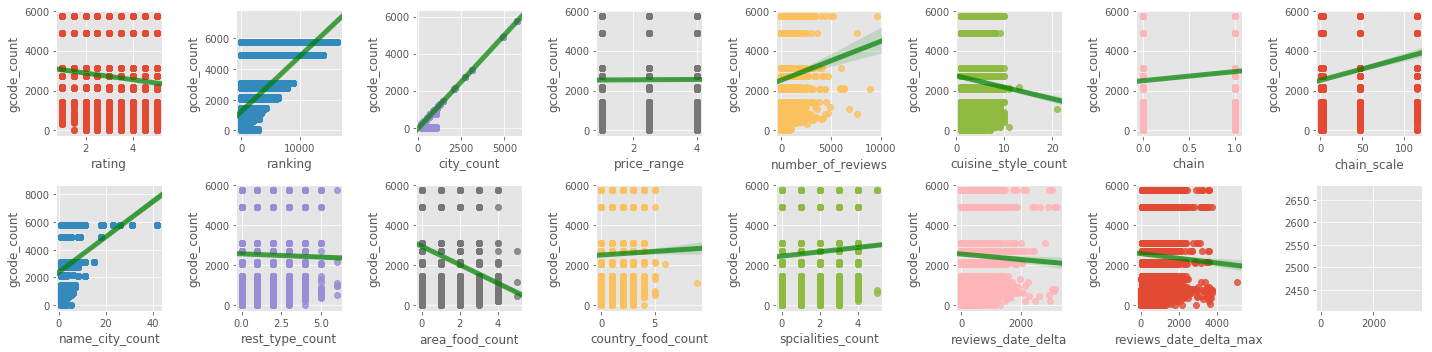

In [40]:
# Let's remember what our numerical data looks like
for col in data_num.columns:
    get_charts(col)

- 'ranking':
    - **numeric** feature
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **city_count, chain_scale, gcode_count, name_city_count, reviews_date_delta, reviews_date_delta_max**
    - has **weak direct** linear correlations with **chain**
    - has **noticeable inverse** linear correlations with **number_of_reviews, rating, cuisine_style_count, area_food_count, spcialities_count**
    - has **weak inverse** linear correlations with **price_range, rest_type_count, country_food_count**
    - ***important*** - remember that at the level of **city** the distribution is almost **uniform**
    - what if log_norm_exp ???
- 'price_range':
    - **categorical** feature
    - pronounced **mode**
    - has **noticeable direct** linear correlations with **number_of_reviews, name_city_count, cuisine_style_count, area_food_count, country_food_count**
    - has **weak direct** linear correlations with **chain_scale, reviews_date_delta_max, spcialities_count**
    - has **noticeable inverse** linear correlations with **reviews_date_delta**
    - has **weak inverse** linear correlations with **ranking, rest_type_count**
- 'number_of_reviews':
    - **numeric** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **cuisine_style_count, spcialities_count**
    - has **weak direct** linear correlations with **area_food_count, country_food_count**
    - has **noticeable inverse** linear correlations with ** **
    - has **weak inverse** linear correlations with **reviews_date_delta_max**
- 'cuisine_style_count':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - **shifted to the right**
    - has **noticeable direct** linear correlations with **number_of_reviews**
    - has **weak direct** linear correlations with **price_range**
    - has **noticeable inverse** linear correlations with **reviews_date_delta, reviews_date_delta_max**
    - has **weak inverse** linear correlations with **ranking**
- 'city_count':
    - **categorical** feature ***???***
    - has **direct** linear correlation with **gcode_count**
    - has **noticeable direct** linear correlations with **ranking, number_of_reviews, chain_scale, name_city_count**
    - has **weak direct** linear correlations with **chain, country_food_count, spcialities_count**
    - has **noticeable inverse** linear correlations with **cuisine_style_count, area_food_count**
    - has **weak inverse** linear correlations with **rating, reviews_date_delta, reviews_date_delta_max**
- 'gcode_count':
    - **categorical** feature ***???***
    - has **direct** linear correlation with **city_count**
    - has **noticeable direct** linear correlations with **ranking, number_of_reviews, chain_scale, name_city_count**
    - has **weak direct** linear correlations with **chain, country_food_count, spcialities_count**
    - has **noticeable inverse** linear correlations with **cuisine_style_count, area_food_count**
    - has **weak inverse** linear correlations with **rating, reviews_date_delta, reviews_date_delta_max**
- 'chain':
    - **categorical** feature
    - pronounced **mode**
    - has **noticeable direct** linear correlations with **name_city_count**
    - has **weak direct** linear correlations with **ranking, city_count, gcode_count, reviews_date_delta, rest_type_count**
    - has **noticeable inverse** linear correlations with ** **
    - has **weak inverse** linear correlations with **price_range, rating, cuisine_style_count, reviews_date_delta_max, area_food_count, country_food_count**
- 'chain_scale':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **ranking, city_count, gcode_count, name_city_count, reviews_date_delta, rest_type_count**
    - has **weak direct** linear correlations with ** **
    - has **noticeable inverse** linear correlations with **price_range, rating, number_of_reviews, area_food_count, country_food_count**
    - has **weak inverse** linear correlations with ** **

- 'reviews_date_delta':
    - **numeric** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with ** **
    - has **weak direct** linear correlations with **reviews_date_delta_max, ranking**
    - has **noticeable inverse** linear correlations with **number_of_reviews**
    - has **weak inverse** linear correlations with **cuisine_style_count, spcialities_count**
- 'reviews_date_delta_max':
    - **numeric** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with ** **
    - has **weak direct** linear correlations with **reviews_date_delta, ranking**
    - has **noticeable inverse**linear correlations with **number_of_reviews**
    - has **weak inverse** linear correlations with **cuisine_style_count, spcialities_count**
- 'rest_type_count':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with ** **
    - has **weak direct** linear correlations with **number_of_reviews, chain_scale, name_city_count**
    - has **noticeable inverse** linear correlations with ** **
    - has **weak inverse** linear correlations with **reviews_date_delta, reviews_date_delta_max, country_food_count**
- 'area_food_count':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **number_of_reviews, country_food_count**
    - has **weak direct** linear correlations with **price_range, rating, spcialities_count**
    - has **noticeable inverse** linear correlations with **reviews_date_delta_max**
    - has **weak inverse** linear correlations with **ranking, city_count, gcode_count, name_city_count, reviews_date_delta**
- 'country_food_count':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **number_of_reviews**
    - has **weak direct** linear correlations with ** **
    - has **noticeable inverse** linear correlations with ** **
    - has **weak inverse** linear correlations with ** **
- 'spcialities_count':
    - **categorical** feature
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **number_of_reviews, area_food_count, country_food_count**
    - has **weak direct** linear correlations with **price_range, rating, name_city_count, rest_type_count**
    - has **noticeable inverse** linear correlations with **reviews_date_delta, reviews_date_delta_max**
    - has **weak inverse** linear correlations with **ranking**
- 'name_city_count':
    - categorical** feature ***???***
    - the presence of **outliers** is pronounced
    - strongly **shifted to the right**
    - has **noticeable direct** linear correlations with **chain_scale**
    - has **weak direct** linear correlations with ** **
    - has **noticeable inverse** linear correlations with **country_food_court**
    - has **weak inverse** linear correlations with ** **
- 'rating':
    - **categorical** feature
    - **shifted to the left**
    - has **noticeable direct** linear correlations with **number_of_reviews, cuisine_style_count**
    - has **weak direct** linear correlations with **specialities_count**
    - has **noticeable inverse** linear correlations with **racing, chain_scale, name_city_count, reviews_date_delta, reviews_date_delta_max**
    - has **weak inverse** linear correlations with ** **

Regroup the conclusions:
- **text** features:
    - city
    - cuisine_style
- **numeric** features:
    - ranking
    - number_of_reviews
    - reviews_date_delta
    - reviews_date_delta_max
    - city_count (***???***)
    - gcode_count (***???***)
    - name_city_count (***???***)
- ** categorical** features:
    - **rating**
    - price_range
    - cuisine_style_count
    - rest_type_count
    - area_food_count
    - country_food_count
    - spcialities_count
    - chain
    - chain_scale
- pronounced **mode**:
    - price_range
    - chain
- the presence of **outliers** is pronounced:
    - number_of_reviews
    - cuisine_style_count
    - rest_type_count
    - area_food_count
    - country_food_count
    - spcialities_count
    - chain_scale
    - name_city_count
    - reviews_date_delta
    - reviews_date_delta_max
- **shifted to the right**:
    - ranking (strongly - at the level of **city** the distribution is almost **uniform**)
    - number_of_reviews (strongly)
    - cuisine_style_count
    - rest_type_count (strongly)
    - area_food_count (strongly)
    - country_food_count (strongly)
    - spcialities_count (strongly)
    - chain_scale (strongly)
    - name_city_count (strongly)
    - reviews_date_delta (strongly)
    - reviews_date_delta_max (strongly)
- **shifted to the left**:
    - **rating**

In [41]:
for col in ['rating', 'price_range', 
            'cuisine_style_count', 'rest_type_count', 'area_food_count', 'country_food_count', 'spcialities_count',
            'chain', 'chain_scale', 'city_count', 'gcode_count', 'name_city_count']:
    print(col, 'unique count:', data[col].nunique())

rating unique count: 10
price_range unique count: 3
cuisine_style_count unique count: 14
rest_type_count unique count: 7
area_food_count unique count: 6
country_food_count unique count: 9
spcialities_count unique count: 6
chain unique count: 2
chain_scale unique count: 4
city_count unique count: 31
gcode_count unique count: 52
name_city_count unique count: 18


In [42]:
data[['rating', 'city_count', 'gcode_count', 'name_city_count']].corr()

rating  city_count  gcode_count  name_city_count
rating           1.000000   -0.014790    -0.014448        -0.013057
city_count      -0.014790    1.000000     0.998279         0.141828
gcode_count     -0.014448    0.998279     1.000000         0.141191
name_city_count -0.013057    0.141828     0.141191         1.000000

For some **numeric** features, we will calculate statistics on the bundle **city** & **categorical/textual** feature. Perhaps this will allow us to get rid of **city** and **cuisine_style** as dummy attributes.

1. rating, ranking **mean** by city -> price_range, chain_scale, cuisine_style
2. number_of_reviews, reviews_date_delta, reviews_date_delta_max **median** by city -> price_range, chain_scale, cuisine_style

In [43]:
from itertools import product

def get_stat_dict(df, cat, num, stat): # stat_list = ['mean', 'median', 'std', 'quant_25', 'quant_75']
    
    cat_num_dict = {}
    
    if stat=='mean':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].mean().reset_index().to_dict('index')}})
        
    elif stat=='median':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].median().reset_index().to_dict('index')}})
        
    elif stat=='std':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].std().reset_index().to_dict('index')}})
    
    elif stat=='quant_25':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].quantile(0.25).reset_index().to_dict('index')}})
        
    elif stat=='quant_75':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].quantile(0.75).reset_index().to_dict('index')}})
        
    cat_num_dict = {k: v[str(cat)] for k, v in cat_num_dict.items()}
    cat_num_dict = {key: {v[str(cat)]: round(v[str(num)], 2) for k, v in cat_num_dict[key].items()} for key, value in cat_num_dict.items()}
    
    
    return cat_num_dict

In [44]:
combinations = list(product(['ranking'], ['price_range', 'chain_scale'], ['mean'])) # cuisine_style
print(len(combinations))

print('Data columns count:', len(data.columns))
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(data.query('sample==1'), comb[1], comb[0], comb[2])
    data['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = data.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

print('Data columns count:', len(data.columns))

for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(data.query('sample==0'), comb[1], comb[0], comb[2])
    data['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = data.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if math.isnan(x['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])])==True and x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else x['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])], axis=1)


2
Data columns count: 53
Data columns count: 55


In [45]:
combinations = list(product(['number_of_reviews', 'reviews_date_delta', 'reviews_date_delta_max'], ['price_range', 'chain_scale'], ['median'])) # cuisine_style
print(len(combinations))

print('Data columns count:', len(data.columns))
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(data.query('sample==1'), comb[1], comb[0], comb[2])
    data['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = data.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

print('Data columns count:', len(data.columns))

for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(data.query('sample==0'), comb[1], comb[0], comb[2])
    data['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = data.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if math.isnan(x['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])])==True and x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else x['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])], axis=1)


6
Data columns count: 55
Data columns count: 61


In [46]:
combinations = list(product(['rating'], ['price_range', 'chain_scale', 'cuisine_style_count'], ['mean'])) # cuisine_style
print(len(combinations))

print('Data columns count:', len(data.columns))
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(data.query('sample==1'), comb[1], comb[0], comb[2])
    data['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = data.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

print('Data columns count:', len(data.columns))

3
Data columns count: 61
Data columns count: 64


In [47]:
print('Data columns count:', len(data.columns))
for col in list(data.columns)[46:]:
    if data[col].isna().sum() > 0:
        print(col, data[col].isna().sum())

Data columns count: 64
number_of_reviews_old_norm 3200
reviews_date_delta_old_norm 8114
reviews_date_delta_max_old_norm 8114
city_rating_cuisine_style_count_mean 5


In [48]:
data[data['city_rating_cuisine_style_count_mean'].isna()==True][['sample', 'city', 'rating', 'cuisine_style', 'cuisine_style_count', 'city_rating_cuisine_style_count_mean']]

sample        city  rating  \
2292       0      Vienna     0.0   
3084       0  Luxembourg     0.0   
5510       0  Copenhagen     0.0   
6348       0      Munich     0.0   
7547       0      Warsaw     0.0   

                                          cuisine_style  cuisine_style_count  \
2292  [German, Austrian, European, Asian, Czech, Eas...                 10.0   
3084  [Spanish, Asian, Thai, Fusion, European, Veget...                  8.0   
5510  [Mexican, Chinese, Japanese, American, Lebanes...                 15.0   
6348  [Italian, Pizza, International, Gastropub, Sea...                 10.0   
7547  [Japanese, Asian, Polish, Fast Food, Mediterra...                 10.0   

      city_rating_cuisine_style_count_mean  
2292                                   NaN  
3084                                   NaN  
5510                                   NaN  
6348                                   NaN  
7547                                   NaN

In [49]:
list(data.columns)[53:64]

['city_ranking_price_range_mean',
 'city_ranking_chain_scale_mean',
 'city_number_of_reviews_price_range_median',
 'city_number_of_reviews_chain_scale_median',
 'city_reviews_date_delta_price_range_median',
 'city_reviews_date_delta_chain_scale_median',
 'city_reviews_date_delta_max_price_range_median',
 'city_reviews_date_delta_max_chain_scale_median',
 'city_rating_price_range_mean',
 'city_rating_chain_scale_mean',
 'city_rating_cuisine_style_count_mean']

In [50]:
features_dict.update({'stat_features': list(data.columns)[53:64]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features'
              ])

Data columns count: 64
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
Columns check: True


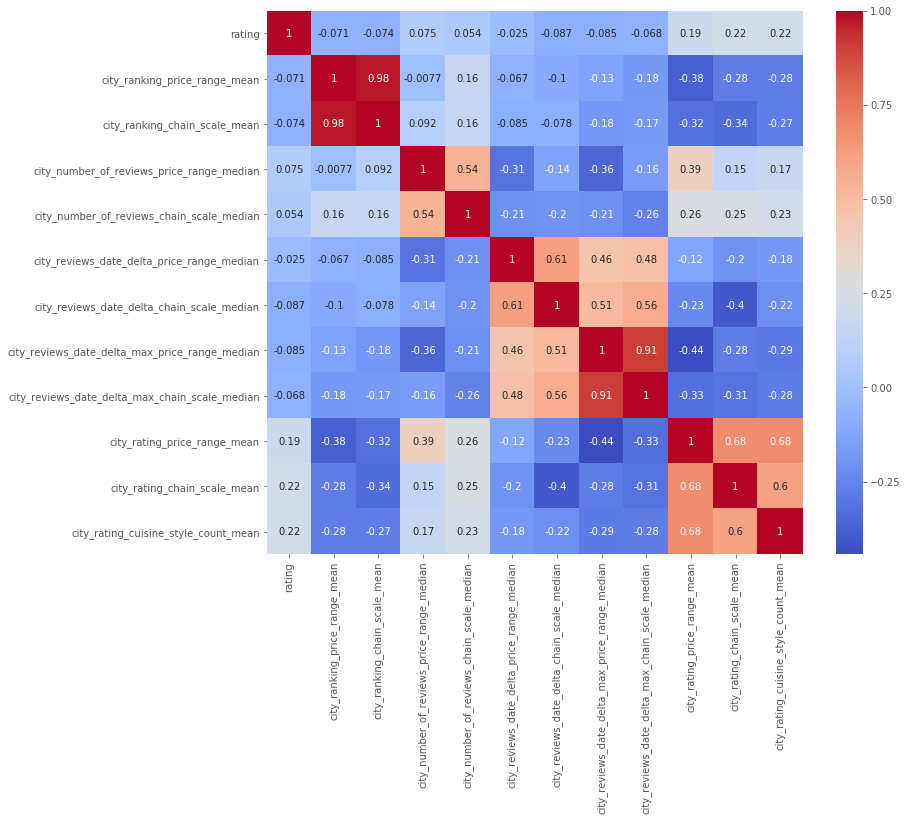

In [51]:
col_list = ['rating', 'sample']
col_list.extend(features_dict['stat_features'])

#plt.rcParams['figure.figsize'] = (40, 40)
sns.heatmap(data.query('sample==1')[col_list].drop('sample', axis=1).copy().corr(), annot=True, cmap='coolwarm')

### additional features

In [52]:
# city can be represented, including the number of chains, as well as 'cheap', 'medium', 'expensive' restaurants

city_chain_dict = pd.DataFrame({'city': sorted(data.city.unique()),
                                'chain': data.loc[(data['sample']==1)&(data['chain']==1)].groupby('city').chain.value_counts().values
                               }).set_index('city').to_dict('index')

data['city_chain'] = data['city'].dropna().apply(lambda x: city_chain_dict[x]['chain'])

# 'cheap', 'medium', 'expensive'
city_price_range_dict = pd.DataFrame({'city': sorted(data.city.unique()),
                                      'cheap': data.loc[(data['sample']==1)&(data['price_range']==1.0)].groupby('city').price_range.value_counts().values,
                                      'medium': data.loc[(data['sample']==1)&(data['price_range']==2.5)].groupby('city').price_range.value_counts().values,
                                      'expensive': data.loc[(data['sample']==1)&(data['price_range']==4.0)].groupby('city').price_range.value_counts().values,
                                      }).set_index('city').to_dict('index')

data['city_cheap'] = data['city'].dropna().apply(lambda x: city_price_range_dict[x]['cheap'])
data['city_medium'] = data['city'].dropna().apply(lambda x: city_price_range_dict[x]['medium'])
data['city_expensive'] = data['city'].dropna().apply(lambda x: city_price_range_dict[x]['expensive'])

# Let's reduce the parametrs correlated with name_count
data['city_chain_scaled'] = data.apply(lambda x: x['city_chain']/x['city_count'], axis=1)
data['city_cheap_scaled'] = data.apply(lambda x: x['city_cheap']/x['city_count'], axis=1)
data['city_medium_scaled'] = data.apply(lambda x: x['city_medium']/x['city_count'], axis=1)
data['city_expensive_scaled'] = data.apply(lambda x: x['city_expensive']/x['city_count'], axis=1)
data['rev_num_city_scaled_old'] = data.apply(lambda x: round(x['number_of_reviews_old']/x['city_count'], 2) if math.isnan(x['number_of_reviews_old'])==False else np.nan, axis=1)


In [53]:
# reviews_text
pos_list = list(set(pos_list))
neg_list = list(set(neg_list))

# count the number of positive and negative words in the reviews
data['reviews_words_list'] = data['reviews_text'].dropna().apply(get_words_list)
data['reviews_pos_score'] = data['reviews_words_list'].dropna().apply(get_positive_score)
data['reviews_neg_score'] = data['reviews_words_list'].dropna().apply(get_negative_score)

data = data.drop('reviews_words_list', axis=1)

print('Total count of reviews_pos_score', data[data['reviews_pos_score']>0].reviews_pos_score.count())
print('Total count of reviews_neg_score', data[data['reviews_neg_score']>0].reviews_neg_score.count())

data[['reviews_pos_score', 'reviews_neg_score']].describe()

Total count of reviews_pos_score 17012
Total count of reviews_neg_score 2733


reviews_pos_score  reviews_neg_score
count       41886.000000       41886.000000
mean            0.517285           0.071265
std             0.712999           0.280702
min             0.000000           0.000000
25%             0.000000           0.000000
50%             0.000000           0.000000
75%             1.000000           0.000000
max             5.000000           3.000000

In [54]:
list(data.columns)[64:75]

['city_chain',
 'city_cheap',
 'city_medium',
 'city_expensive',
 'city_chain_scaled',
 'city_cheap_scaled',
 'city_medium_scaled',
 'city_expensive_scaled',
 'rev_num_city_scaled_old',
 'reviews_pos_score',
 'reviews_neg_score']

In [55]:
features_dict.update({'count_features': list(data.columns)[64:75]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features'
              ])

Data columns count: 75
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
Columns check: True


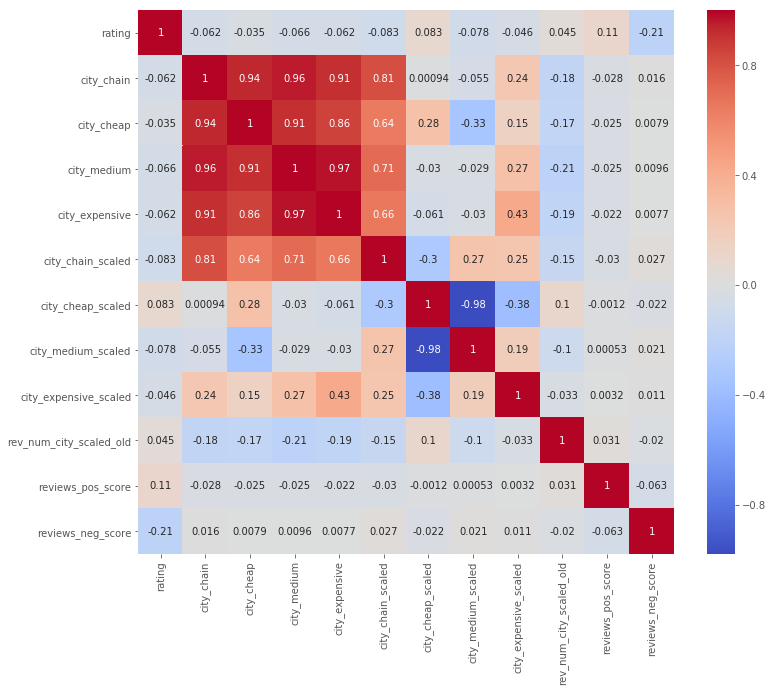

In [56]:
col_list = ['rating', 'sample']
col_list.extend(features_dict['count_features'])

plt.rcParams['figure.figsize'] = (12, 10)
sns.heatmap(data.query('sample==1')[col_list].drop('sample', axis=1).copy().corr(), annot=True, cmap='coolwarm')

## **Polynomial features**
It is often useful to complicate the model, taking into account ** non-linear features of the input data**.

For example, pairwise multiplication of existing columns to obtain nonlinear combinations of features. Another example is the squaring of features or the root of a feature to get artificial features.

In [57]:
from sklearn.preprocessing import PolynomialFeatures

The `Polynomial Features` class from the `sklearn` library accepts a set of features as input and outputs polynomial features generated based on the input and with a degree less than or equal to the specified one.

For example, for features `[a, b]` and degree `2`, it will return `[1, a, b, a^2, ab, b^2]`.

In [58]:
P = data[['ranking', 'city_count', 'number_of_reviews_old']].copy().fillna(0)
print(P.head(1), end='\n\n')

poly = PolynomialFeatures(2) # , interaction_only=True
# [[1, a, b, c, a^2, ab, ac, b^2, bc, c^2]]
# [[1, a, b, c, ab, ac, bc]] # a^2, b^2, c^2

# [[1, a, b, c, d, a^2, ab, ac, ad, b^2, bc, bd, c^2, cd, d^2]]
P_poly = poly.fit_transform(P)

P_poly[0]

   ranking  city_count  number_of_reviews_old
0  12963.0        4897                    4.0



array([1.00000000e+00, 1.29630000e+04, 4.89700000e+03, 4.00000000e+00,
       1.68039369e+08, 6.34798110e+07, 5.18520000e+04, 2.39806090e+07,
       1.95880000e+04, 1.60000000e+01])

In [59]:
P_poly_df = pd.DataFrame(P_poly,
                         columns = ['1', 'ranking', 'city_count', 'number_of_reviews_old', 
                                    'ranking^2', 'ranking*city_count', 'ranking*number_of_reviews_old',
                                    'city_count^2', 'city_count*number_of_reviews_old', 'number_of_reviews_old^2'
                                   ]
                        )
P_poly_df.head(1)

1  ranking  city_count  number_of_reviews_old    ranking^2  \
0  1.0  12963.0      4897.0                    4.0  168039369.0   

   ranking*city_count  ranking*number_of_reviews_old  city_count^2  \
0          63479811.0                        51852.0    23980609.0   

   city_count*number_of_reviews_old  number_of_reviews_old^2  
0                           19588.0                     16.0

In [60]:
poly_features = list(P_poly_df.columns)[4:]
print('poly_features cout:', len(poly_features))
poly_features

poly_features cout: 6


['ranking^2',
 'ranking*city_count',
 'ranking*number_of_reviews_old',
 'city_count^2',
 'city_count*number_of_reviews_old',
 'number_of_reviews_old^2']

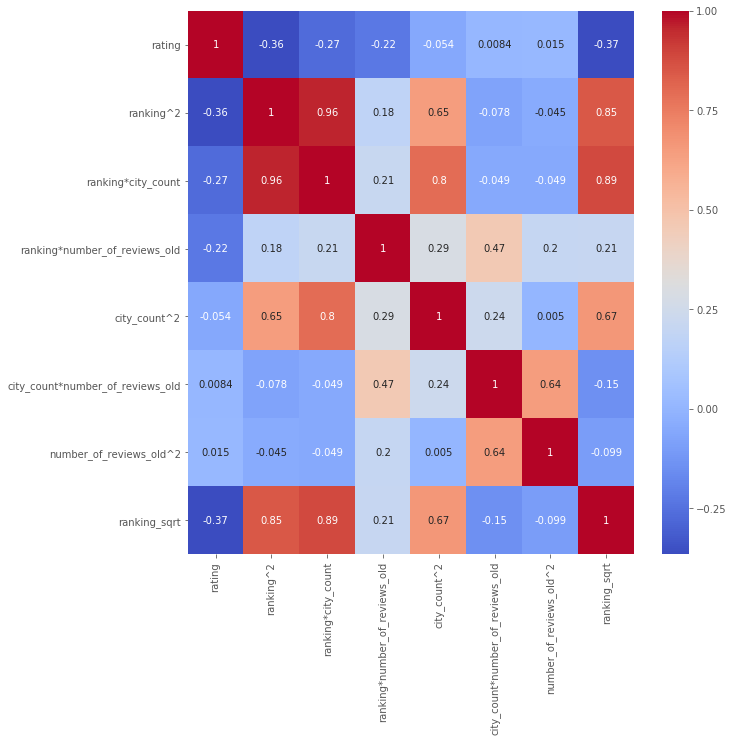

In [61]:
data_poly = pd.concat([data[['rating', 'sample', 'ranking']],
                       P_poly_df[poly_features]
                      ], axis=1)

data_poly['ranking_sqrt'] = data_poly['ranking'].dropna().apply(lambda x: np.sqrt(x))

plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(data_poly.query('sample==1').drop(['sample', 'ranking'], axis=1).copy().corr(),
            annot=True, cmap='coolwarm')

In [62]:
data = pd.concat([data, P_poly_df[poly_features]], axis=1) # по вертикали
data['ranking_sqrt'] = data_poly['ranking'].dropna().apply(lambda x: np.sqrt(x))

list(data.columns)[75:82]

['ranking^2',
 'ranking*city_count',
 'ranking*number_of_reviews_old',
 'city_count^2',
 'city_count*number_of_reviews_old',
 'number_of_reviews_old^2',
 'ranking_sqrt']

In [63]:
features_dict.update({'nlarge_poly_features': list(data.columns)[75:82]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features', 'nlarge_poly_features'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features'
              ])

Data columns count: 82
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
Columns check: True


In [64]:
P = data[['ranking_city_scaled', 'number_of_reviews_old', 'reviews_date_delta_max_old']].copy().fillna(0)
print(P.head(1), end='\n\n')

poly = PolynomialFeatures(2) # , interaction_only=True
# [[1, a, b, c, a^2, ab, ac, b^2, bc, c^2]]
# [[1, a, b, c, ab, ac, bc]] # a^2, b^2, c^2

# [[1, a, b, c, d, a^2, ab, ac, ad, b^2, bc, bd, c^2, cd, d^2]]
P_poly = poly.fit_transform(P)

P_poly[0]

   ranking_city_scaled  number_of_reviews_old  reviews_date_delta_max_old
0                 2.65                    4.0                         0.0



array([ 1.    ,  2.65  ,  4.    ,  0.    ,  7.0225, 10.6   ,  0.    ,
       16.    ,  0.    ,  0.    ])

In [65]:
P_poly_df = pd.DataFrame(P_poly,
                         columns = ['1', 'ranking_city_scaled', 'number_of_reviews_old', 'reviews_date_delta_max_old', 
                                    'ranking_city_scaled^2', 'ranking_city_scaled*number_of_reviews_old', 'ranking_city_scaled*reviews_date_delta_max_old',
                                    'number_of_reviews_old^2', 'number_of_reviews_old*reviews_date_delta_max_old', 'reviews_date_delta_max_old^2'
                                   ]
                        )
P_poly_df.head(1)

1  ranking_city_scaled  number_of_reviews_old  \
0  1.0                 2.65                    4.0   

   reviews_date_delta_max_old  ranking_city_scaled^2  \
0                         0.0                 7.0225   

   ranking_city_scaled*number_of_reviews_old  \
0                                       10.6   

   ranking_city_scaled*reviews_date_delta_max_old  number_of_reviews_old^2  \
0                                             0.0                     16.0   

   number_of_reviews_old*reviews_date_delta_max_old  \
0                                               0.0   

   reviews_date_delta_max_old^2  
0                           0.0

In [66]:
poly_features = list(P_poly_df.columns)[4:]
print('poly_features cout:', len(poly_features))
poly_features

poly_features cout: 6


['ranking_city_scaled^2',
 'ranking_city_scaled*number_of_reviews_old',
 'ranking_city_scaled*reviews_date_delta_max_old',
 'number_of_reviews_old^2',
 'number_of_reviews_old*reviews_date_delta_max_old',
 'reviews_date_delta_max_old^2']

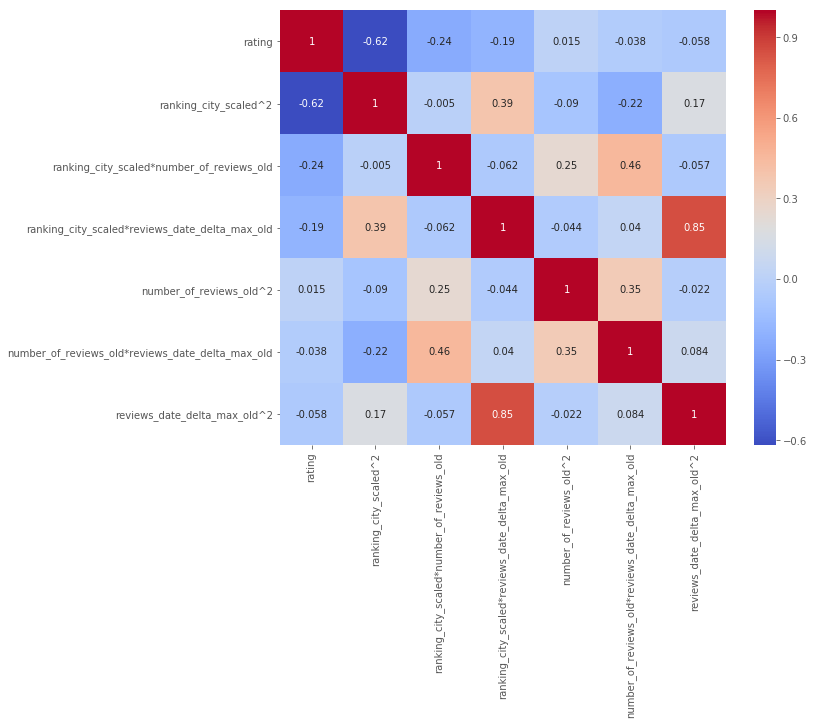

In [67]:
data_poly = pd.concat([data[['rating', 'sample']],
                       P_poly_df[poly_features]
                      ], axis=1)

plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(data_poly.query('sample==1').drop('sample', axis=1).copy().corr(),
            annot=True, cmap='coolwarm')

In [68]:
data = pd.concat([data, P_poly_df[poly_features]], axis=1) # по вертикали

list(data.columns)[82:88]

['ranking_city_scaled^2',
 'ranking_city_scaled*number_of_reviews_old',
 'ranking_city_scaled*reviews_date_delta_max_old',
 'number_of_reviews_old^2',
 'number_of_reviews_old*reviews_date_delta_max_old',
 'reviews_date_delta_max_old^2']

In [69]:
features_dict.update({'other_poly_features': list(data.columns)[82:88]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features', 'nlarge_poly_features', 'other_poly_features'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features', 'other_poly_features'
              ])

Data columns count: 88
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
Columns check: True


## Dummy

### cuisine_style

In [70]:
# make a dictionary of the Cuisine Style frequency taking into account a certain parameter
def cuisine_count_dict(cell):
    c = collections.Counter()
    for el in cell:
        if el is not np.nan:
            if type(el)==list:
                for x in el:
                    c[x]+=1
            else:
                c[el]+=1
    
    c = {k: v for k, v in sorted(c.items(), key=by_value, reverse=True)}
    return c


# sort the dictionary in descending order of quantity
def by_value(item):
    return item[1]

In [71]:
# city - cuisine_style
city_style = data.query('sample==1').groupby('city')['cuisine_style'].apply(list).reset_index()
city_style['cuisine_style'] = city_style['cuisine_style'].apply(cuisine_count_dict)

city_style_dict_1 = city_style.set_index('city').to_dict('index')
city_style_dict_1 = {k: v['cuisine_style'] for k, v in city_style_dict_1.items()}
# 'Amsterdam': {'European': 501, 'Vegetarian Friendly': 469, 'Dutch': 286, ... }


city_style = data.query('sample==0').groupby('city')['cuisine_style'].apply(list).reset_index()
city_style['cuisine_style'] = city_style['cuisine_style'].apply(cuisine_count_dict)

city_style_dict_0 = city_style.set_index('city').to_dict('index')
city_style_dict_0 = {k: v['cuisine_style'] for k, v in city_style_dict_0.items()}


print('train dataset:', city_style_dict_1['Amsterdam']['European'])
print('test dataset:', city_style_dict_0['Amsterdam']['European'])

train dataset: 501
test dataset: 117


In [72]:
style_list = []
for cuisine in data['cuisine_style'].copy().dropna():
    for style in cuisine:
        if not(style in style_list):
            style_list.append(style)
            
len(style_list)

125

In [73]:
def find_item(cell):
    if item in cell:
        return 1
    return 0

data['cuisine_style'] = data['cuisine_style'].fillna('-')

for item in style_list:
    data[item] = data['cuisine_style'].apply(find_item)

In [74]:
data[list(data.columns)[88:213]].describe()

Bar           Pub      European  Scandinavian  \
count  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.081880      0.061160      0.251220      0.008980   
std        0.274185      0.239626      0.433719      0.094337   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       Gluten Free Options  Vegetarian Friendly  Vegan Options       Italian  \
count         50000.000000         50000.000000   50000.000000  50000.000000   
mean              0.103700             0.280420       0.113680      0.148660   
std               0.304874             0.449209       0.317425      0.355757   
min               0.000000             0.000000       0.000000      0.000000   
25%               0.000000             0.000000       0.000000      0.000000   
50%               0.000000             0.000000       0.000000      0.000000   
75%               0.000000             1.000000       0.000000      0.000000   
max               1.000000             1.000000       1.000000      1.000000   

       Mediterranean       Seafood  ...      Albanian  Central Asian  \
count   50000.000000  50000.000000  ...  50000.000000    50000.00000   
mean        0.156400      0.037560  ...      0.000160        0.00024   
std         0.363238      0.190131  ...      0.012648        0.01549   
min         0.000000      0.000000  ...      0.000000        0.00000   
25%         0.000000      0.000000  ...      0.000000        0.00000   
50%         0.000000      0.000000  ...      0.000000        0.00000   
75%         0.000000      0.000000  ...      0.000000        0.00000   
max         1.000000      1.000000  ...      1.000000        1.00000   

         Polynesian     Caucasian       Uzbek    Salvadoran      Xinjiang  \
count  50000.000000  50000.000000  50000.0000  50000.000000  50000.000000   
mean       0.000040      0.000080      0.0001      0.000020      0.000020   
std        0.006324      0.008944      0.0100      0.004472      0.004472   
min        0.000000      0.000000      0.0000      0.000000      0.000000   
25%        0.000000      0.000000      0.0000      0.000000      0.000000   
50%        0.000000      0.000000      0.0000      0.000000      0.000000   
75%        0.000000      0.000000      0.0000      0.000000      0.000000   
max        1.000000      1.000000      1.0000      1.000000      1.000000   

            Burmese        Fujian       Latvian  
count  50000.000000  50000.000000  50000.000000  
mean       0.000020      0.000040      0.000020  
std        0.004472      0.006324      0.004472  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000  

[8 rows x 125 columns]

In [75]:
features_dict.update({'cuisine_dummy': list(data.columns)[88:213]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features', 'nlarge_poly_features', 'other_poly_features',
# 'cuisine_count_dummy', 'cuisine_dummy'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features', 'other_poly_features',
               'cuisine_dummy'
              ])

Data columns count: 213
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
cuisine_dummy count: 125
Columns check: True


In [76]:
print('Data columns count:', len(list(data.columns)))
for item in style_list:
    data['_'.join([str(item), 'count'])] = data.apply(lambda x: city_style_dict_1[x['city']][item] if item in x['cuisine_style'] and item in city_style_dict_1[x['city']] else (city_style_dict_0[x['city']][item] if item in x['cuisine_style'] and item in city_style_dict_0[x['city']] else 0), axis=1)

print('Data columns count:', len(list(data.columns)))
213+125

Data columns count: 213
Data columns count: 338


338

In [77]:
data[list(data.columns)[213:338]].describe()

Bar_count     Pub_count  European_count  Scandinavian_count  \
count  50000.000000  50000.000000    50000.000000         50000.00000   
mean      23.820700     14.717600      132.452420             0.71024   
std      112.938146     84.564193      284.774904             7.99901   
min        0.000000      0.000000        0.000000             0.00000   
25%        0.000000      0.000000        0.000000             0.00000   
50%        0.000000      0.000000        0.000000             0.00000   
75%        0.000000      0.000000       59.000000             0.00000   
max      772.000000    651.000000     1247.000000           104.00000   

       Gluten Free Options_count  Vegetarian Friendly_count  \
count               50000.000000               50000.000000   
mean                   47.371760                 236.517940   
std                   202.903305                 542.892354   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                 177.000000   
max                  1173.000000                2205.000000   

       Vegan Options_count  Italian_count  Mediterranean_count  Seafood_count  \
count         50000.000000   50000.000000         50000.000000   50000.000000   
mean             41.308540      99.390500            86.416560       6.104420   
std             159.210381     312.195157           244.071593      38.790707   
min               0.000000       0.000000             0.000000       0.000000   
25%               0.000000       0.000000             0.000000       0.000000   
50%               0.000000       0.000000             0.000000       0.000000   
75%               0.000000       0.000000             0.000000       0.000000   
max             951.000000    1403.000000          1079.000000     304.000000   

       ...  Albanian_count  Central Asian_count  Polynesian_count  \
count  ...    50000.000000         50000.000000      50000.000000   
mean   ...        0.000200             0.000520          0.000040   
std    ...        0.016732             0.036328          0.006324   
min    ...        0.000000             0.000000          0.000000   
25%    ...        0.000000             0.000000          0.000000   
50%    ...        0.000000             0.000000          0.000000   
75%    ...        0.000000             0.000000          0.000000   
max    ...        2.000000             3.000000          1.000000   

       Caucasian_count   Uzbek_count  Salvadoran_count  Xinjiang_count  \
count     50000.000000  50000.000000      50000.000000    50000.000000   
mean          0.000080      0.000140          0.000020        0.000020   
std           0.008944      0.014832          0.004472        0.004472   
min           0.000000      0.000000          0.000000        0.000000   
25%           0.000000      0.000000          0.000000        0.000000   
50%           0.000000      0.000000          0.000000        0.000000   
75%           0.000000      0.000000          0.000000        0.000000   
max           1.000000      2.000000          1.000000        1.000000   

       Burmese_count  Fujian_count  Latvian_count  
count   50000.000000  50000.000000   50000.000000  
mean        0.000020      0.000040       0.000020  
std         0.004472      0.006324       0.004472  
min         0.000000      0.000000       0.000000  
25%         0.000000      0.000000       0.000000  
50%         0.000000      0.000000       0.000000  
75%         0.000000      0.000000       0.000000  
max         1.000000      1.000000       1.000000  

[8 rows x 125 columns]

In [78]:
features_dict.update({'cuisine_count_dummy': list(data.columns)[213:338]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features', 'nlarge_poly_features', 'other_poly_features',
# 'cuisine_count_dummy'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features', 'other_poly_features',
               'cuisine_dummy', 'cuisine_count_dummy'
              ])

Data columns count: 338
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
cuisine_dummy count: 125
cuisine_count_dummy count: 125
Columns check: True


### city

In [79]:
print('Data columns count:', len(data.columns))
data = pd.get_dummies(data, columns=['city'], dummy_na=True)
print('Data columns count:', len(data.columns))

Data columns count: 338
Data columns count: 369


In [80]:
features_dict.update({'city_dummy': list(data.columns)[338:369]})

# 'common_features', 'old_features', 'new_features', 'add_com_features', 'add_old_features', 'add_new_features',
# 'norm_features', 'stat_features', 'count_features', 'nlarge_poly_features', 'other_poly_features',
# 'cuisine_count_dummy', 'cuisine_dummy', 'city_dummy'
check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features', 'other_poly_features',
               'cuisine_dummy', 'cuisine_count_dummy', 'city_dummy'
              ])

Data columns count: 369
not_relvant count: 11
common_features count: 6
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
cuisine_dummy count: 125
cuisine_count_dummy count: 125
city_dummy count: 31
Columns check: True


In [81]:
features_dict.update({'common_features': remove_elments(features_dict['common_features'], ['city'])})

check_columns(['common_features', 'old_features', 'new_features', 
               'add_com_features', 'add_old_features', 'add_new_features',
               'norm_features', 'stat_features', 'count_features',
               'nlarge_poly_features', 'other_poly_features',
               'cuisine_dummy', 'cuisine_count_dummy', 'city_dummy'
              ])

Data columns count: 369
not_relvant count: 11
common_features count: 5
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
cuisine_dummy count: 125
cuisine_count_dummy count: 125
city_dummy count: 31
Columns check: False


## Second set of tests

In [82]:
                                    # + additional features norm with NaNs
models_dict = {'add_features_norm': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_old_features', 'norm_features']), ['number_of_reviews_old', 'reviews_date_delta_old', 'reviews_date_delta_max_old', 'ranking_city_scaled', 'ranking_norm', 'ranking_norm_log', 'ranking_log_norm']),
                                     'MAE': 0,
                                     'Train_r2_score': 0,
                                     'Test r2_score': 0,
                                     'nlargest': 0
                                     },
                                     # + additional & statistic features with NaNs
               'add_stat_features': {'columns': get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'stat_features']),
                                     'MAE': 0,
                                     'Train_r2_score': 0,
                                     'Test r2_score': 0,
                                     'nlargest': 0
                                     },
                                     # + additional & statistic + new counts & words features with NaNs
               'add_stat_count_features': {'columns': get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'stat_features', 'count_features']),
                                           'MAE': 0,
                                           'Train_r2_score': 0,
                                           'Test r2_score': 0,
                                           'nlargest': 0
                                           },
                                     # + all additional & 3 large polynomial with original features with NaNs
               'add_nlarge_w_o_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features']), ['ranking_sqrt']),
                                           'MAE': 0,
                                           'Train_r2_score': 0,
                                           'Test r2_score': 0,
                                           'nlargest': 0
                                           },
                                     # + all additional & 3 large polynomial without original features with NaNs
               'add_nlarge_wo_o_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features']), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # + all additional & 3 large polynomial + ranking_sqrt without original features with NaNs
               'add_nlarge_sqrt_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features']), ['ranking', 'city_count', 'number_of_reviews_old']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # + all additional & 3 large polynomial interaction only with original features with NaNs
               'add_nlarge_inter_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features']), ['ranking_sqrt', 'ranking^2', 'city_count^2', 'number_of_reviews_old^2']),
                                             'MAE': 0,
                                             'Train_r2_score': 0,
                                             'Test r2_score': 0,
                                             'nlargest': 0
                                             },
                                     # + all additional & 3 other polynomial without original features with NaNs
               'add_other_poly_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'other_poly_features']), ['number_of_reviews_old', 'reviews_date_delta_max_old']),
                                           'MAE': 0,
                                           'Train_r2_score': 0,
                                           'Test r2_score': 0,
                                           'nlargest': 0
                                           },
                                     # + all additional & 3 other polynomial interaction only with original features with NaNs
               'add_other_inter_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'other_poly_features']), ['ranking_city_scaled^2', 'number_of_reviews_old^2', 'reviews_date_delta_max_old^2']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # + all additional & 3 large polynomial without original & statistic features with NaNs
               'add_nlarge_stat_features': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features']), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # all additional & statistics & 3 large polynomial without original & cuisines dummy counts with NaNs
               'add_nlarge_stat_cois_c_dum': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'cuisine_count_dummy']), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old']),
                                              'MAE': 0,
                                              'Train_r2_score': 0,
                                              'Test r2_score': 0,
                                              'nlargest': 0
                                              },
                                     # all additional & statistics & 3 large polynomial without original & cuisines dummy with NaNs
               'add_nlarge_stat_cois_dum': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'cuisine_dummy']), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            },
                                     # all additional & statistics & 3 large polynomial without original & city dummy with NaNs
               'add_nlarge_stat_city_dum': {'columns': remove_elments(get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'city_dummy']), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old']),
                                            'MAE': 0,
                                            'Train_r2_score': 0,
                                            'Test r2_score': 0,
                                            'nlargest': 0
                                            }

              }


In [83]:
for model_name in models_dict.keys():
    print(model_name)
    model_tests(model_name)

add_features_norm


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_stat_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_stat_count_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_w_o_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_wo_o_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_sqrt_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_inter_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_other_poly_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_other_inter_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_stat_features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_stat_cois_c_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_stat_cois_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_nlarge_stat_city_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [84]:
models_df_1

columns  \
first_view_ranking         [sample, rating, city, cuisine_style, ranking,...   
first_view_ranking_wo      [sample, rating, city, cuisine_style, ranking,...   
first_view_rank_scl        [sample, rating, city, cuisine_style, city_cou...   
first_view_ranking_wo_cc   [sample, rating, city, cuisine_style, ranking,...   
first_view_rank_scl_wo_cc  [sample, rating, city, cuisine_style, price_ra...   
first_view_rank_norm       [sample, rating, city, cuisine_style, city_cou...   
first_view_rank_n_log      [sample, rating, city, cuisine_style, city_cou...   
first_view_rank_log_n      [sample, rating, city, cuisine_style, city_cou...   
add_features_old           [sample, rating, city, cuisine_style, ranking,...   
add_features_new           [sample, rating, city, cuisine_style, ranking,...   

                                MAE  Train_r2_score  Test r2_score  \
first_view_ranking         0.211712        0.969294       0.775145   
first_view_ranking_wo      0.223051        0.967054       0.752034   
first_view_rank_scl        0.216355        0.964866       0.770943   
first_view_ranking_wo_cc   0.405017        0.891186       0.255503   
first_view_rank_scl_wo_cc  0.277344        0.895534       0.644955   
first_view_rank_norm       0.215019        0.968643       0.780040   
first_view_rank_n_log      0.214888        0.968642       0.780266   
first_view_rank_log_n      0.213499        0.969252       0.781111   
add_features_old           0.207568        0.970733       0.782424   
add_features_new           0.219269        0.968460       0.763024   

                                                                    nlargest  
first_view_ranking         ranking                    0.528484
city_count...  
first_view_ranking_wo      ranking                0.542849
city_count    ...  
first_view_rank_scl        ranking_city_scaled        0.645799
number_of_...  
first_view_ranking_wo_cc   ranking                    0.667834
number_of_...  
first_view_rank_scl_wo_cc  ranking_city_scaled        0.704091
number_of_...  
first_view_rank_norm       ranking_norm               0.676704
number_of_...  
first_view_rank_n_log      ranking_norm_log           0.676708
number_of_...  
first_view_rank_log_n      ranking_log_norm           0.661419
number_of_...  
add_features_old           ranking                       0.490143
city_co...  
add_features_new           ranking                   0.493755
city_count ...

In [85]:
models_df_1.loc['first_view_ranking']['nlargest']

ranking                    0.528484
city_count                 0.258685
number_of_reviews_old      0.173484
cuisine_style_count_old    0.025816
price_range_old            0.013531
dtype: float64

In [86]:
models_df_1.loc['add_features_old']['nlargest']

ranking                       0.490143
city_count                    0.251112
number_of_reviews_old         0.151403
reviews_date_delta_max_old    0.034290
reviews_date_delta_old        0.025271
cuisine_style_count_old       0.011579
price_range_old               0.007638
rest_type_count_old           0.006611
dtype: float64

In [87]:
models_df_2 = pd.DataFrame.from_dict(models_dict, orient='index')
models_df_2

columns  \
add_features_norm           [sample, rating, cuisine_style, ranking, city_...   
add_stat_features           [sample, rating, cuisine_style, ranking, city_...   
add_stat_count_features     [sample, rating, cuisine_style, ranking, city_...   
add_nlarge_w_o_features     [sample, rating, cuisine_style, ranking, city_...   
add_nlarge_wo_o_features    [sample, rating, cuisine_style, price_range_ol...   
add_nlarge_sqrt_features    [sample, rating, cuisine_style, price_range_ol...   
add_nlarge_inter_features   [sample, rating, cuisine_style, ranking, city_...   
add_other_poly_features     [sample, rating, cuisine_style, ranking, city_...   
add_other_inter_features    [sample, rating, cuisine_style, ranking, city_...   
add_nlarge_stat_features    [sample, rating, cuisine_style, price_range_ol...   
add_nlarge_stat_cois_c_dum  [sample, rating, cuisine_style, price_range_ol...   
add_nlarge_stat_cois_dum    [sample, rating, cuisine_style, price_range_ol...   
add_nlarge_stat_city_dum    [sample, rating, cuisine_style, price_range_ol...   

                                 MAE  Train_r2_score  Test r2_score  \
add_features_norm           0.207509        0.970744       0.782164   
add_stat_features           0.204596        0.971287       0.784884   
add_stat_count_features     0.203541        0.971507       0.786068   
add_nlarge_w_o_features     0.201091        0.971854       0.790723   
add_nlarge_wo_o_features    0.201170        0.971811       0.790467   
add_nlarge_sqrt_features    0.201269        0.971807       0.790873   
add_nlarge_inter_features   0.201254        0.971796       0.790569   
add_other_poly_features     0.199717        0.972059       0.794727   
add_other_inter_features    0.202777        0.971463       0.787057   
add_nlarge_stat_features    0.201735        0.971743       0.789094   
add_nlarge_stat_cois_c_dum  0.200879        0.971724       0.790716   
add_nlarge_stat_cois_dum    0.201139        0.971771       0.789821   
add_nlarge_stat_city_dum    0.201607        0.971751       0.788595   

                                                                     nlargest  
add_features_norm           ranking                            0.493684
ci...  
add_stat_features           ranking                                       ...  
add_stat_count_features     ranking                       0.516468
number_...  
add_nlarge_w_o_features     ranking^2                        0.244749
rank...  
add_nlarge_wo_o_features    ranking^2                        0.443568
rank...  
add_nlarge_sqrt_features    ranking_sqrt                     0.247604
rank...  
add_nlarge_inter_features   ranking                          0.444150
rank...  
add_other_poly_features     ranking_city_scaled^2                         ...  
add_other_inter_features    ranking                                       ...  
add_nlarge_stat_features    ranking^2                        0.442427
rank...  
add_nlarge_stat_cois_c_dum  ranking^2                        0.437188
rank...  
add_nlarge_stat_cois_dum    ranking^2                        0.438758
rank...  
add_nlarge_stat_city_dum    ranking^2                        0.442570
rank...

In [88]:
print(models_df_2.loc['add_nlarge_stat_cois_c_dum']['MAE'])
models_df_2.loc['add_nlarge_wo_o_features']['nlargest']

0.20087937499999997


ranking^2                        0.443568
ranking*number_of_reviews_old    0.147178
ranking*city_count               0.065296
city_cheap                       0.063492
city_count^2                     0.059652
city_medium                      0.038970
reviews_date_delta_max_old       0.025981
reviews_date_delta_old           0.017675
dtype: float64

In [89]:
print(models_df_2.loc['add_nlarge_stat_city_dum']['MAE'])
models_df_2.loc['add_nlarge_stat_features']['nlargest']

0.201606875


ranking^2                        0.442427
ranking*number_of_reviews_old    0.145209
city_cheap                       0.059485
ranking*city_count               0.056926
city_count^2                     0.047852
city_medium                      0.032552
reviews_date_delta_max_old       0.024316
rev_num_city_scaled_old          0.016948
dtype: float64

**Second set of test**:
1. Normalization **number_of_reviews_old, reviews_date_delta_old, reviews_date_delta_max_old** slightly improved the result.
2. Indicators of the number of restaurants of a certain price segment in the city reduce the error, but they drag over the importance of **city_count, number_of_reviews_old**, increasing the importance of **ranking** even more (perhaps, increases the instability of the model).
3. Polynomial features composed of the three most important features (**ranking, city_count, number_of_reviews_old**), together with the original features, work slightly better than without them (0.2011 vs 0.2012 MAE) - **ranking** and **ranking^2** divide the significance in half.
4. The model (0.1997 MAE) turned out to be even better, in which **ranking_city_scaled, number_of_reviews_old, reviews_date_delta_max_old** were taken for polynomial features. The most important ones are: **ranking_city_scaled^2** (0.55) and **ranking_city_scaled*number_of_reviews_old** (0.17).
5. Dummy features by cuisines, where instead of 1 the number of restaurants with this cuisine in the city was indicated gives a better result than the usual dummy features (0.2008 vs 0.2011 MAE).
6. Any of the dummy features by cuisines give a better result than dummy features by cities (0.2011 vs 0.2016 MAE).


## Third set of test

In [90]:
               # all additional without statistics & 3 norm & 3 large + 3 other polynomial without original & cuisine count + city dummy with NaNs
models_dict = {'add_poly_wo_o_norm_dum': {'columns': remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old', 'reviews_date_delta_max_old']),
                                          'MAE': 0,
                                          'Train_r2_score': 0,
                                          'Test r2_score': 0,
                                          'nlargest': 0
                                         },
               # all additional with statistics & 3 norm & 3 large + 3 other polynomial without original & cuisine count + city dummy with NaNs
               'add_poly_wo_o_stat_norm_dum': {'columns': remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old', 'reviews_date_delta_max_old']),
                                               'MAE': 0,
                                               'Train_r2_score': 0,
                                               'Test r2_score': 0,
                                               'nlargest': 0
                                              },
               # all additional without statistics & 3 norm & 3 large + 3 other polynomial with original & cuisine count + city dummy with NaNs
               'add_poly_w_o_norm_dum': {'columns': remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['ranking_city_scaled', 'number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt']),
                                         'MAE': 0,
                                         'Train_r2_score': 0,
                                         'Test r2_score': 0,
                                         'nlargest': 0
                                         },
               # all additional with statistics & 3 norm & 3 large + 3 other polynomial with original & cuisine count + city dummy with NaNs
               'add_poly_w_o_stat_norm_dum': {'columns': remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['ranking_city_scaled', 'number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt']),
                                              'MAE': 0,
                                              'Train_r2_score': 0,
                                              'Test r2_score': 0,
                                              'nlargest': 0
                                             },
              }


In [91]:
for model_name in models_dict.keys():
    print(model_name)
    model_tests(model_name)

add_poly_wo_o_norm_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_poly_wo_o_stat_norm_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_poly_w_o_norm_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


add_poly_w_o_stat_norm_dum


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [92]:
models_df_3 = pd.DataFrame.from_dict(models_dict, orient='index')
models_df_3

columns  \
add_poly_wo_o_norm_dum       [sample, rating, cuisine_style, price_range_ol...   
add_poly_wo_o_stat_norm_dum  [sample, rating, cuisine_style, price_range_ol...   
add_poly_w_o_norm_dum        [sample, rating, cuisine_style, ranking, city_...   
add_poly_w_o_stat_norm_dum   [sample, rating, cuisine_style, ranking, city_...   

                                  MAE  Train_r2_score  Test r2_score  \
add_poly_wo_o_norm_dum       0.198927        0.972110       0.794892   
add_poly_wo_o_stat_norm_dum  0.198137        0.972314       0.797377   
add_poly_w_o_norm_dum        0.198891        0.972122       0.795611   
add_poly_w_o_stat_norm_dum   0.198376        0.972281       0.796969   

                                                                      nlargest  
add_poly_wo_o_norm_dum       ranking_city_scaled^2                         ...  
add_poly_wo_o_stat_norm_dum  ranking_city_scaled^2                        0...  
add_poly_w_o_norm_dum        ranking_city_scaled                          0...  
add_poly_w_o_stat_norm_dum   ranking_city_scaled                          0...

In [93]:
# BEST MODEL
print(models_df_3.loc['add_poly_wo_o_stat_norm_dum']['MAE'])
models_df_3.loc['add_poly_wo_o_stat_norm_dum']['nlargest']

0.1981375


ranking_city_scaled^2                        0.546393
ranking_city_scaled*number_of_reviews_old    0.155729
ranking^2                                    0.021510
city_Rome                                    0.020756
city_rating_chain_scale_mean                 0.018019
city_rating_cuisine_style_count_mean         0.017014
city_rating_price_range_mean                 0.014644
ranking*number_of_reviews_old                0.014279
dtype: float64

## FINAL MODEL

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.1981375


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Train r2_score: 0.9723141710773471


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Test r2_score: 0.7973772304700433

Model parametrs:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


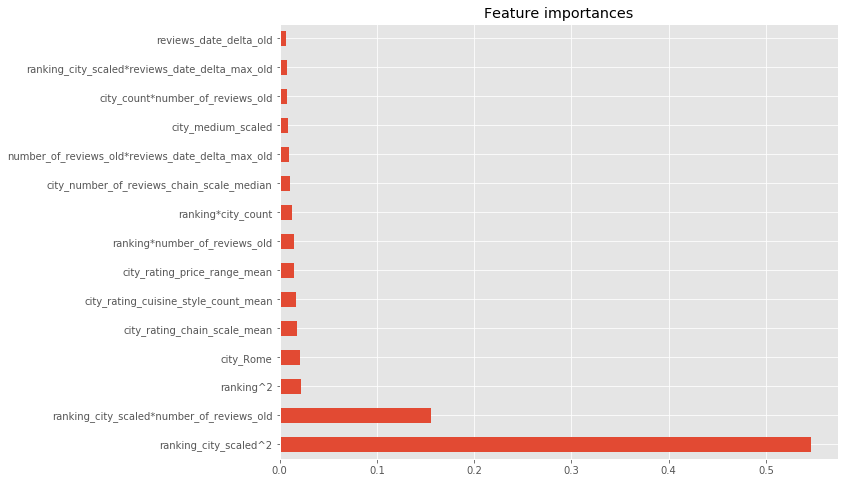

In [94]:
# CHECK the best model

# all additional with statistics & 3 norm & 3 large + 3 other polynomial without original & cuisine count + city dummy with NaNs
data_num = data[remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old', 'reviews_date_delta_max_old'])].select_dtypes(include='number').copy()
data_num = data_num.fillna(0)                                               

model, X, y = modelizer(data_num)
# MAE: 0.1981375

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.1676875


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Train r2_score: 0.9723141710773471
Test r2_score: 0.7973772304700433

Model parametrs:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


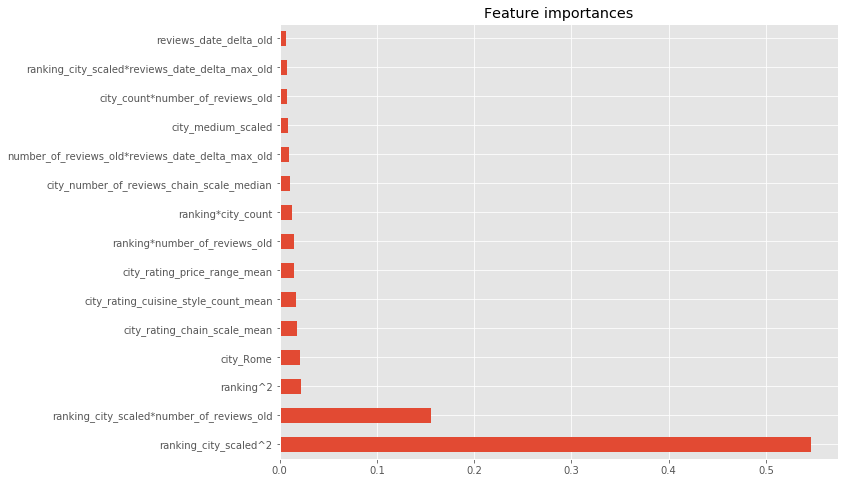

In [95]:
# ROUND Y

# all additional with statistics & 3 norm & 3 large + 3 other polynomial without original & cuisine count + city dummy with NaNs
data_num = data[remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old', 'reviews_date_delta_max_old'])].select_dtypes(include='number').copy()
data_num = data_num.fillna(0)                                               

model, X, y = modelizer_round(data_num)
# y_pred_round_array: 0.1676875 (last time: 0.1699375)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

[train] r2_score = 0.97 +/- 0.00
[valid] r2_score = 0.80 +/- 0.00


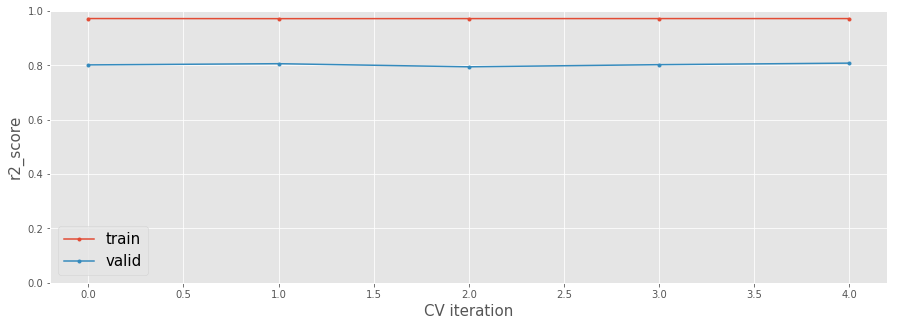

In [96]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='r2', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

**Underfitting** — a problem in which the algorithm has not studied the data well enough and misses important dependencies between features. In the case of underfitting, we cannot even achieve acceptable estimates for the model based on training data.

Why can there be underfitting?
- Incorrectly selected learning algorithm
- Inadequate error function
- Hyperparameters are not configured or incorrectly configured

How to get rid of underfitting?
- Complication of the model
- Weakening of regularization parameters

**Third set of test**:
- all additional features & statistics & 3 normalized features & 3 large + 3 other polynomial features without original & cuisine count + city dummy features with NaNs - **THE BEST MODEL** (0.198 MAE)
- the most important features of which:
    - ranking_city_scaled^2 - 0.55
    - ranking_city_scaled*number_of_reviews_old - 0.16
- rounding predict with pitch 0.5 to make continious number discrete turn MAE 0.1981375 into 0.1676875

# Submission

In [97]:
test_data = data_num.query('sample == 0').drop(['sample', 'rating'], axis=1)
test_data.sample(5)

price_range_old  cuisine_style_count_old  chain  chain_scale  \
2008              1.0                      3.0      0            1   
3178              1.0                      8.0      0            1   
8189              2.5                      4.0      0            1   
9018              2.5                      4.0      0            1   
9589              2.5                      3.0      0            1   

      name_city_count  rest_type_count_old  area_food_count_old  \
2008                1                  2.0                  0.0   
3178                1                  1.0                  2.0   
8189                1                  1.0                  1.0   
9018                1                  2.0                  0.0   
9589                1                  0.0                  2.0   

      country_food_count_old  spcialities_count_old  reviews_date_delta_old  \
2008                     1.0                    0.0                   104.0   
3178                     2.0                    3.0                   132.0   
8189                     1.0                    1.0                     8.0   
9018                     1.0                    1.0                    32.0   
9589                     1.0                    0.0                   115.0   

      ...  city_Prague  city_Rome  city_Stockholm  city_Vienna  city_Warsaw  \
2008  ...            0          0               0            0            0   
3178  ...            0          0               0            0            0   
8189  ...            0          0               0            0            0   
9018  ...            0          0               0            0            0   
9589  ...            0          0               0            0            0   

      city_Zurich  city_nan  number_of_reviews_old_norm  \
2008            0         0                    0.005177   
3178            0         0                    0.062642   
8189            0         0                    0.052495   
9018            0         0                    0.016670   
9589            0         0                    0.022158   

      reviews_date_delta_old_norm  reviews_date_delta_max_old_norm  
2008                     0.032429                         0.012848  
3178                     0.041160                         0.028464  
8189                     0.002495                         0.049417  
9018                     0.009978                         0.035185  
9589                     0.035859                         0.174540  

[5 rows x 205 columns]

In [98]:
sample_submission.sample(5)

Restaurant_id  Rating
9479       id_9479     1.0
5074       id_5074     2.0
9332       id_9332     2.0
4700       id_4700     1.0
3188       id_3188     1.5

In [99]:
predict_submission = model.predict(test_data)
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


array([3.025, 4.165, 4.275, ..., 3.005, 4.48 , 4.395])

In [100]:
# rounding predict with pitch 0.5
predict_submission_round = []
for item in predict_submission:
    predict_submission_round.append(round(item/0.5)*0.5)

predict_submission_array = np.asarray(predict_submission_round)
predict_submission_array

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [101]:
sample_submission['Rating'] = predict_submission_array
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

Restaurant_id  Rating
0          id_0     3.0
1          id_1     4.0
2          id_2     4.5
3          id_3     4.5
4          id_4     4.5